####  <b> Introduction： </b>

My past job experience including an internship had granted my exposure to data analytics projects related to occupational therapies and occupational health. To handle work injury cases, typically the data administer would record all the event dates, beginning from the occurrence of injury, along the timelines of diagnosis, recovery training, compensation applications, discharge, return-to-work, etc. Because of this nature, it is contextually fit for most common survival analysis (time-to-event) modelling methods.

<br>

I am trying to reconstruct a similar analysis using a publicly available dataset of worker compensation claims in the United States (US) from the year 2000, which would include three major goals:
<ul>
<li>
Kaplan-Meier estimator for deriving by-group survival curves and functions
</li>
<li>
Log-rank test for doing hypothesis testing on significant differences in survival times between groups
</li>
<li>
a set of parametric and machine learning (ML) models for predicting the hazards (likelihood of event occurrence and its time until occurrence)：
<ul>
<li>
Cox Proportional Hazards (Cox PH) regression model
</li>
<li>
Survival Support Vector Machine (SVM)
</li>
<li>
Survival Forest (or other Ensembles)
</li>
<li>
Survival Gradient Boosting models (GBM)
</li>
</ul>
</li>
</ul>

<br>

For deciding the predictors (explanatory variables), I manually pick up some key demographic attributes, including: <br>
1) Gender; <br>
2) Accident / Occupational Disease; <br>
3) Types of the injury claims; <br>
4) Districts of legal processing; <br>
5) Counties / Locations where the injury took place;

<br>

The targeted outcome would be the time difference (in days) from the accident (injury) date to the ANCR date (settlement date). Only those completed cases marked either with "Administatively Closed" or "No Further Action" were retained. "Age of Injury" and "Average Weekly Wages" were two covariates used as control variables to estimate more accurately the effects of the explanatory variables.

<br>

Since fitting models for each level of the dummy categorical variables above would generate long printed outputs in the notebook, I intentionally keep one for demonstration (Accident vs Occupational Disease), and would summarise all the numerical results in a summarised HTML table at the bottom of the notebook.

<br>

For several text features documenting some complementary metadata, like the injured positions, types of injuries, inspected reasons of injuries, exposure and sources of hazards in the surrounding environment when the injury took place. These features were standardized in national codes, which might be important in outcome predictions. However, the obstacle would be the manual efforts needed to annotate several groupings based on the text contents, and the curse of high dimensionality. A general idea would be combining the texts, and adopting PCA (principal components) or SVD (singular value decomposition) to trim down the number of variables. The principal components could show the major grouping patterns (proximity of loadings / weightings) of the variables, accounting for any combination of the dummy text features that were of high likelihood of co-occurrence.

<br>

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from collections import Counter

from matplotlib import pyplot as plt
import plotly
import plotly.tools as tls
import plotly.graph_objs as go

In [ ]:
!unzip /content/drive/MyDrive/Colab\ Notebooks/public\ healthcare\ research/work-injury-claim-data.zip

Archive:  /content/drive/MyDrive/Colab Notebooks/public healthcare research/work-injury-claim-data.zip
  inflating: Assembled_Workers__Compensation_Claims___Beginning_2000.csv  


In [ ]:
df = pd.read_csv("Assembled_Workers__Compensation_Claims___Beginning_2000.csv")

In [ ]:
print(df.shape)
print(df.columns)

(2729794, 52)
Index(['index', 'Claim Identifier', 'Claim Type', 'District Name',
       'Average Weekly Wage', 'Current Claim Status', 'Claim Injury Type',
       'Age at Injury', 'Assembly Date', 'Accident Date', 'ANCR Date',
       'Controverted Date', 'Section 32 Date', 'PPD Scheduled Loss Date',
       'PPD Non-Scheduled Loss Date', 'PTD Date', 'First Appeal Date',
       'WCIO Part Of Body Code', 'WCIO Part Of Body Description',
       'WCIO Nature of Injury Code', 'WCIO Nature of Injury Description',
       'WCIO Cause of Injury Code', 'WCIO Cause of Injury Description',
       'OIICS Part Of Body Code', 'OIICS Part Of Body Description',
       'OIICS Nature of Injury Code', 'OIICS Nature of Injury Description',
       'OIICS Injury Source Code', 'OIICS Injury Source Description',
       'OIICS Event Exposure Code', 'OIICS Event Exposure Description',
       'OIICS Secondary Source Code', 'OIICS Secondary Source Description',
       'Alternative Dispute Resolution', 'Gender', 'Bi

In [ ]:
###### check claim type distribution
Counter(df['Claim Type'])

Counter({'Workers Compensation': 2709076,
         'WTC Volunteer': 1942,
         'Volunteer Ambulance Worker': 1808,
         'Volunteer Firefighter': 16968})

In [ ]:
###### check claim type distribution
Counter(df['Current Claim Status'])

Counter({'NO FURTHER ACTION': 2127318,
         'ADMINISTRATIVELY CLOSED': 240808,
         'CASE CANCELLED': 67529,
         'REOPENED': 63697,
         'NEWLY ASSEMBLED': 230349,
         'UNKNOWN': 93})

In [ ]:
###### check state/district distribution for legal processing
Counter(df['District Name'])

Counter({'NYC': 1014259,
         'Hempstead': 117821,
         'Hauppauge': 270446,
         'Peekskill': 184165,
         'Albany': 334092,
         'Syracuse': 224582,
         'Rochester': 219751,
         'Buffalo': 250558,
         'Binghamton': 114120})

In [ ]:
###### check state/county distribution for injury locations
Counter(df['County of Injury'])

Counter({'QUEENS': 246117,
         'BRONX': 139652,
         'KINGS': 213214,
         'NEW YORK': 288505,
         'UNKNOWN': 46994,
         'RICHMOND': 53233,
         'WESTCHESTER': 114617,
         'ALBANY': 60560,
         'MONROE': 123046,
         'NASSAU': 181956,
         'ONEIDA': 40609,
         'ORANGE': 63259,
         'ROCKLAND': 34611,
         'SUFFOLK': 238983,
         'CHENANGO': 7641,
         'PUTNAM': 11171,
         'DUTCHESS': 45583,
         'SULLIVAN': 12926,
         'SARATOGA': 29733,
         'ULSTER': 26901,
         'ONTARIO': 18903,
         'RENSSELAER': 21204,
         'SCHENECTADY': 18085,
         'MONTGOMERY': 6618,
         'WARREN': 12815,
         'COLUMBIA': 11207,
         'GREENE': 8450,
         'ALLEGANY': 7182,
         'ONONDAGA': 88116,
         'SCHOHARIE': 3410,
         'JEFFERSON': 14942,
         'CAYUGA': 17328,
         'CLINTON': 13982,
         'FULTON': 12398,
         'FRANKLIN': 8945,
         'OSWEGO': 16453,
         'WASH

In [ ]:
###### check Accident distribution
Counter(df['Accident'])

Counter({'Y': 2674281, 'N': 55513})

In [ ]:
###### check Occupational Disease distribution
Counter(df['Occupational Disease'])

Counter({'N': 2674281, 'Y': 55513})

In [3]:
##### data cleansing
df['Average Weekly Wage'] = df['Average Weekly Wage'].apply(lambda x: float(str(x).replace("$", "")))
##### data truncating
df = df[(df['Claim Type'] == 'Workers Compensation') &
        (df['Current Claim Status'].isin(['NO FURTHER ACTION', 'ADMINISTRATIVELY CLOSED'])) &
        pd.notnull(df['Accident Date']) &
        pd.notnull(df['ANCR Date']) &
        pd.notnull(df['Assembly Date']) &
        pd.notnull(df['Average Weekly Wage']) &
        pd.notnull(df['Birth Year']) &
        pd.notnull(df['OIICS Part Of Body Description']) &
        pd.notnull(df['OIICS Nature of Injury Description']) &
        pd.notnull(df['OIICS Injury Source Description']) &
        pd.notnull(df['OIICS Event Exposure Description']) &
        pd.notnull(df['WCIO Part Of Body Description']) &
        pd.notnull(df['WCIO Nature of Injury Description']) &
        pd.notnull(df['WCIO Cause of Injury Description'])]

In [ ]:
print(df.shape)

(114029, 52)


In [4]:
###  quick fix for a few columns
df['constant'] = 1
df['Injury Type'] = df.apply(lambda x: 'Accident' if x['Accident'] == "Y" else 'Occupational Disease', axis = 1)

###  define columns
date_cols = [x for x in df.columns if "date" in x.lower()]
pivot_date_cols = ['Assembly Date', 'Accident Date', 'ANCR Date', 'C-2 Date', 'C-3 Date', 'First Hearing Date']
pivot_group_cols = ['District Name','County of Injury','Claim Injury Type','Injury Type']
description_cols = ['WCIO Part Of Body Description',
                    'WCIO Nature of Injury Description',
                    'WCIO Cause of Injury Description',
                    'OIICS Part Of Body Description',
                    'OIICS Nature of Injury Description',
                    'OIICS Injury Source Description',
                    'OIICS Event Exposure Description']

###  engineer time difference columns
for n in pivot_date_cols:
    df[n] = df[n].apply(lambda x: datetime.strptime(x, "%m/%d/%Y") if pd.isnull(x) == False else x)

df['acci_2_assem'] = (df['Assembly Date'] - df['Accident Date']).dt.days
df['acci_2_hearing'] = (df['First Hearing Date'] - df['Accident Date']).dt.days
df['acci_2_c2'] = (df['C-2 Date'] - df['Accident Date']).dt.days
df['acci_2_c3'] = (df['C-3 Date'] - df['Accident Date']).dt.days
df['acci_2_ancr'] = (df['ANCR Date'] - df['Accident Date']).dt.days

###  justify -ve time differences
df['acci_2_assem'] = df['acci_2_assem'].apply(lambda x: x * -1 if x < 0 else x)
df['acci_2_hearing'] = df['acci_2_hearing'].apply(lambda x: x * -1 if x < 0 else x)
df['acci_2_c2'] = df['acci_2_c2'].apply(lambda x: x * -1 if x < 0 else x)
df['acci_2_c3'] = df['acci_2_c3'].apply(lambda x: x * -1 if x < 0 else x)
df['acci_2_ancr'] = df['acci_2_ancr'].apply(lambda x: x * -1 if x < 0 else x)

In [5]:
###  engineer text features
for x in description_cols:
    df[x] =df[x].apply(lambda x: x.lower())

df['WCIO Part Of Body Description'] = df['WCIO Part Of Body Description'].\
    apply(lambda x:
          'multiple body parts' if 'multiple body parts' in x or x == 'whole body'
          else x)

df['WCIO Nature of Injury Description'] = df['WCIO Nature of Injury Description'].\
    apply(lambda x:
          'hearing loss or impairment' if x == 'loss of hearing' else
          'mental_disorder' if x == 'mental_stress' else
          x.replace(", noc", ""))

df['WCIO Cause of Injury Description'] = df['WCIO Cause of Injury Description'].\
    apply(lambda x:
          'moving parts of machine' if x == 'moving part of machine' else
          'object being lifted or handled' if x == 'object handled' else
          'hand tool or machine in use' if x == 'using tool or machinery' else
          'operation' if 'operation' in x else
          'natural or weather factors' if x in ['temperature extremes','natural disasters','abnormal air pressure'] else
          'human violence' if x in ['terrorism','fellow worker, patient or other person','gunshot','struck or injured'] else
          'fall, slip or trip ' + x if x in ['on stairs','on same level','on ice or snow','into openings'] else
          'crash of vehicles' if 'crash ' in x else
          x.replace(", noc", ""))

df['OIICS Part Of Body Description'] = df['OIICS Part Of Body Description'].\
      apply(lambda x:
            'trunk' if 'trunk' in x else
            'lower extremities' if 'lower extremities' in x else
            'upper extremities' if 'upper extremities' in x else
            'head' if 'head' in x else
            'larynx, pharynx, vocal cord(s)' if x in ['larynx','pharynx','vocal cord(s)'] else
            x.replace(", noc", ""))

df['OIICS Nature of Injury Description'] = df['OIICS Nature of Injury Description'].\
      apply(lambda x:
            'neoplasms or tumors' if 'neoplasms' in x or 'tumors' in x else
            'systemic diseases and disorders' if 'systemic diseases and disorders' in x else
            'traumatic injuries and disorders' if 'traumatic injuries and disorders' in x else
            x.replace(", n.e.c.", ""))

df['OIICS Injury Source Description'] = df['OIICS Injury Source Description'].\
      apply(lambda x:
            'furniture' if 'furniture' in x else
            'containers' if 'containers' in x else
            'structures' if 'structures' in x else
            'parts and materials' if 'parts and materials' in x else
            'metallic' if x.startswith('metallic') else
            'machinery, miscellaneous' if x == 'machinery, unspecified' else
            'tools, instruments, and equipment, other' if x == 'tools, instruments, and equipment, unspecified' else
            'chemicals' if 'chemical' in x or x == 'alkalies' or x == 'acids' or 'hydrocarbon' in x or 'halogen' in x else
            'vehicles, others' if x in ['vehicles, n.e.c.','vehicle, unspecified'] else
            'animals and animal products' if x == 'persons, plants, animals, and minerals, n.e.c.' else
            x.replace(", n.e.c.", ""))

df['OIICS Event Exposure Description'] = df['OIICS Event Exposure Description'].\
      apply(lambda x:
            'assaults and violent acts by person(s)' if x == 'assaults and violent acts, unspecified' else
            'bodily reaction' if 'bodily reaction' in x or 'bodily conditions' in x else
            'contact with objects and equipment' if 'contact with objects and equipment' in x else
            'exposure to harmful substances or environments' if 'exposure to harmful substances or environments' in x else
            'rubbed or abraded' if 'rubbed' in x and 'abraded' in x else
            'fall, others' if x == 'fall, unspecified' or x == 'fall, n.e.c.' else
            'fire or explosion' if 'fire' in x or 'explosion' in x else
            'transportation accident' if 'transportation accident' in x or x in ['aircraft accident','water vehicle accident'] else
            'repetitive motion' if x == 'sustained viewing' else
            'caught in or compressed by equipment or objects' if 'caught in' in x else
            x.replace(", n.e.c.", ""))

In [ ]:
df[description_cols].nunique()

WCIO Part Of Body Description         51
WCIO Nature of Injury Description     51
WCIO Cause of Injury Description      62
OIICS Part Of Body Description        26
OIICS Nature of Injury Description    27
OIICS Injury Source Description       64
OIICS Event Exposure Description      31
dtype: int64

In [ ]:
df[description_cols].nunique().sum()

312

In [ ]:
###  prepare dummy variables for Injury Description features
occurrences = list()
for n in description_cols:
    occurrences.append(pd.get_dummies(df[n]))
occurrences_matrix = pd.concat(occurrences, axis = 1)

In [ ]:
###  Using SVD to reduce the dimensionality of the dummy variables
from sklearn.decomposition import TruncatedSVD
pca_results = list()

pca = TruncatedSVD(n_components = 2)
pca_fit = pca.fit(occurrences_matrix)
pca_results.append(pca_fit)

for n in range(10, 210, 10):
    pca = TruncatedSVD(n_components = n)
    pca_fit = pca.fit(occurrences_matrix)
    pca_results.append(pca_fit)

Text(0.5, 1.0, 'Truncated SVD explained variances')

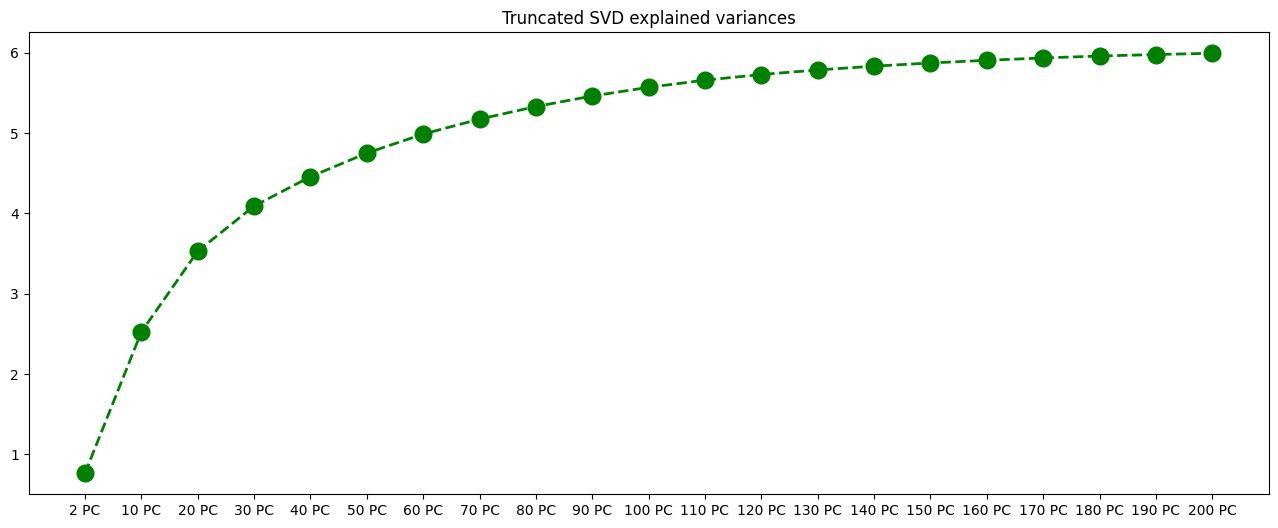

In [ ]:
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (16,6)
plt.plot(
    [str(2) + " PC"] + [str(x) + " PC" for x in range(10, 210, 10)],
    [0.7655571170017497] + [np.sum(x.explained_variance_) for x in pca_results],
    'go--', linewidth=2, markersize=12
)
plt.title("Truncated SVD explained variances")

In [ ]:
###  final decision:  30 components
pca = TruncatedSVD(n_components = 30)
pca_fit = pca.fit(occurrences_matrix)
pc = pca_fit.transform(occurrences_matrix)
pc_loadings = pca_fit.components_

In [ ]:
pc.shape

(114029, 30)

In [ ]:
pc_loadings.shape

(30, 312)

In [ ]:
##  find patterns in PCs
feature_names = pca_fit.feature_names_in_.tolist()
feature_loadings = pd.DataFrame(np.transpose(pc_loadings))
feature_loadings.columns = ['PC_' + str(x+1) for x in range(30)]
feature_loadings["feature"] = pd.Series(feature_names)

In [ ]:
##  inspect high- and low- features in each PC
for p in range(30):
    print("PC_" + str(p+1) + " : ")
    print("High Loading Features : ")
    print(feature_loadings[feature_loadings["PC_" + str(p+1)] >= 0.2]['feature'].values.tolist())
    print("Low Loading Features : ")
    print(feature_loadings[feature_loadings["PC_" + str(p+1)] <= -0.2]['feature'].values.tolist())
    print("\n")

<html xmlns:v="urn:schemas-microsoft-com:vml"
xmlns:o="urn:schemas-microsoft-com:office:office"
xmlns:x="urn:schemas-microsoft-com:office:excel"
xmlns="http://www.w3.org/TR/REC-html40">

<head>
<meta http-equiv=Content-Type content="text/html; charset=windows-1252">
<meta name=ProgId content=Excel.Sheet>
<meta name=Generator content="Microsoft Excel 15">
<link id=Main-File rel=Main-File
href="../work-injury-claim-data-output-compilation.html">
<link rel=File-List href=filelist.xml>
<link rel=Stylesheet href=stylesheet.css>
<style>
<!--table
	{mso-displayed-decimal-separator:"\.";
	mso-displayed-thousand-separator:"\,";}
@page
	{margin:.75in .7in .75in .7in;
	mso-header-margin:.3in;
	mso-footer-margin:.3in;}
-->
</style>
</head>

<body link="#0563C1" vlink="#954F72">

<table border=0 cellpadding=0 cellspacing=0 width=759 style='border-collapse:
 collapse;table-layout:fixed;width:569pt'>
 <col width=61 style='mso-width-source:userset;mso-width-alt:2230;width:46pt'>
 <col width=347 style='mso-width-source:userset;mso-width-alt:12690;width:260pt'>
 <col width=351 style='mso-width-source:userset;mso-width-alt:12836;width:263pt'>
 <col width=291 style='mso-width-source:userset;mso-width-alt:10642;width:218pt'>
 <col width=209 style='mso-width-source:userset;mso-width-alt:7643;width:157pt'>
 <col width=291 style='mso-width-source:userset;mso-width-alt:10642;width:218pt'>
 <col width=306 style='mso-width-source:userset;mso-width-alt:11190;width:230pt'>
 <col width=211 style='mso-width-source:userset;mso-width-alt:7716;width:158pt'>
 <col width=80 style='mso-width-source:userset;mso-width-alt:2925;width:60pt'>
 <tr height=20 style='height:15.0pt'>
  <td height=20 width=61 style='height:15.0pt;width:46pt'></td>
  <th width=347 style='width:260pt'><span style='mso-spacerun:yes'><p style="font-weight:bold">Yes  (Positive)</p></span></th>
  <th width=351 style='width:263pt'><span style='mso-spacerun:yes'><p style="font-weight:bold">No  (Negative)</p></span></th>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 colspan=3 style='height:15.0pt;mso-ignore:colspan'></td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'>PC1</td>
  <td>lower back area;<span style='mso-spacerun:yes'>  </span>back, including
  spine, spinal cord</td>
  <td></td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td>traumatic injuries to bones, nerves, spinal cord</td>
  <td></td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td>traumatic injuries to muscles, tendons, joints, etc.</td>
  <td></td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td>floors, walkways, ground surfaces</td>
  <td></td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td>strain or tear</td>
  <td></td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td>lifting</td>
  <td></td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td>overexertion</td>
  <td></td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 colspan=3 style='height:15.0pt;mso-ignore:colspan'></td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'>PC3</td>
  <td>lower back area;<span style='mso-spacerun:yes'>  </span>back, including
  spine, spinal cord</td>
  <td>multiple body parts</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td>traumatic injuries to bones, nerves, spinal cord</td>
  <td>traumatic injuries to muscles, tendons, joints, etc.</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 colspan=3 style='height:15.0pt;mso-ignore:colspan'></td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'>PC7</td>
  <td>lower back area;<span style='mso-spacerun:yes'>  </span>back, including
  spine, spinal cord</td>
  <td>shoulder(s)</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td>highway vehicle, motorized</td>
  <td>shoulder, including clavicle, scapula</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 colspan=2 style='height:15.0pt;mso-ignore:colspan'></td>
  <td>strain or tear</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 colspan=3 style='height:15.0pt;mso-ignore:colspan'></td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'>PC25</td>
  <td>back, including spine, spinal cord</td>
  <td>lower back area</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td>disc</td>
  <td>multiple body parts</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 colspan=3 style='height:15.0pt;mso-ignore:colspan'></td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'>PC16</td>
  <td>back, including spine, spinal cord</td>
  <td>lower back area</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td>multiple body parts</td>
  <td>multiple body parts</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td>traumatic injuries and disorders</td>
  <td></td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 colspan=3 style='height:15.0pt;mso-ignore:colspan'></td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'>PC5</td>
  <td>multiple body parts</td>
  <td>back, including spine, spinal cord</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td>traumatic injuries and disorders</td>
  <td>traumatic injuries to muscles, tendons, joints, etc.</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td>highway vehicle, motorized</td>
  <td>floors, walkways, ground surfaces</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td>highway accident</td>
  <td>fall on same level</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td>strain or tear</td>
  <td></td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 colspan=3 style='height:15.0pt;mso-ignore:colspan'></td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'>PC6</td>
  <td>shoulder(s)</td>
  <td>lower back area;<span style='mso-spacerun:yes'>  </span>back, including
  spine, spinal cord</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td>shoulder, including clavicle, scapula</td>
  <td>sprain or tear</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td>traumatic injuries to bones, nerves, spinal cord</td>
  <td>person--injured or ill worker</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td>overexertion</td>
  <td></td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td></td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'>PC8</td>
  <td>shoulder(s)</td>
  <td>knee;<span style='mso-spacerun:yes'>  </span>leg(s)</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td>shoulder, including clavicle, scapula</td>
  <td></td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td>wrist(s)</td>
  <td></td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td>person--injured or ill worker</td>
  <td></td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td>repetitive motion</td>
  <td></td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 colspan=3 style='height:15.0pt;mso-ignore:colspan'></td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'>PC13</td>
  <td>shoulder(s)</td>
  <td>multiple body parts</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td>shoulder, including clavicle, scapula</td>
  <td>person--other than injured or ill worker</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td>lower back area</td>
  <td>assaults and violent acts by person(s)</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td>traumatic injuries and disorders</td>
  <td></td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td>fall to lower level</td>
  <td></td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 colspan=3 style='height:15.0pt;mso-ignore:colspan'></td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'>PC2</td>
  <td>traumatic injuries to bones, nerves, spinal cord</td>
  <td>lifting</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td>floors, walkways, ground surfaces</td>
  <td>overexertion</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td>fall on same level</td>
  <td></td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 colspan=3 style='height:15.0pt;mso-ignore:colspan'></td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'>PC11</td>
  <td>floors, walkways, ground surfaces</td>
  <td>highway vehicle, motorized</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td>fall to lower level</td>
  <td>fall on same level</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 colspan=2 style='height:15.0pt;mso-ignore:colspan'></td>
  <td>contusion</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 colspan=3 style='height:15.0pt;mso-ignore:colspan'></td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'>PC4</td>
  <td>knee;<span style='mso-spacerun:yes'>  </span>leg(s)</td>
  <td>floors, walkways, ground surfaces</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td>person--injured or ill worker</td>
  <td></td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td>bodily reaction</td>
  <td></td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 colspan=3 style='height:15.0pt;mso-ignore:colspan'></td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'>PC15</td>
  <td>wrist(s)</td>
  <td>multiple body parts</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td>highway vehicle, motorized</td>
  <td>person--injured or ill worker</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td>sprain or tear</td>
  <td>bodily reaction</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 colspan=3 style='height:15.0pt;mso-ignore:colspan'></td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'>PC27</td>
  <td>wrist;<span style='mso-spacerun:yes'>  </span>wrist(s)</td>
  <td>ankle;<span style='mso-spacerun:yes'>  </span>ankle (s)</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td>neck, external</td>
  <td>repetitive motion</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td>fall, slip or trip on same level</td>
  <td></td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td>bodily reaction</td>
  <td></td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 colspan=3 style='height:15.0pt;mso-ignore:colspan'></td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'>PC26</td>
  <td>neck, external</td>
  <td>all other specific injuries</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td>cranial region, including skull</td>
  <td>wrist;<span style='mso-spacerun:yes'>  </span>wrist(s)</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td>intracranial injuries</td>
  <td></td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td>dislocation</td>
  <td></td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 colspan=3 style='height:15.0pt;mso-ignore:colspan'></td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'>PC30</td>
  <td>cranial region, including skull</td>
  <td>neck, external</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td>intracranial injuries</td>
  <td></td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td>fracture</td>
  <td></td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 colspan=3 style='height:15.0pt;mso-ignore:colspan'></td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'>PC24</td>
  <td>finger(s)</td>
  <td>falling or flying object</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td>finger(s), fingernail(s)</td>
  <td>struck by object</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td>open wounds</td>
  <td>strain or tear</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td>containers</td>
  <td></td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 colspan=3 style='height:15.0pt;mso-ignore:colspan'></td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'>PC19</td>
  <td>ankle;<span style='mso-spacerun:yes'>  </span>ankle (s)</td>
  <td>lower back area</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td>traumatic injuries and disorders</td>
  <td>multiple body parts</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td>fracture</td>
  <td>struck by object</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 colspan=3 style='height:15.0pt;mso-ignore:colspan'></td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'>PC29</td>
  <td>elbow</td>
  <td>ankle;<span style='mso-spacerun:yes'>  </span>ankle (s)</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td>arm(s)</td>
  <td>wrist;<span style='mso-spacerun:yes'>  </span>wrist(s)</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td>fracture</td>
  <td></td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 colspan=3 style='height:15.0pt;mso-ignore:colspan'></td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'>PC9</td>
  <td>traumatic injuries and disorders</td>
  <td>traumatic injuries to bones, nerves, spinal cord</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td>contusion</td>
  <td>traumatic injuries to muscles, tendons, joints, etc.</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td>lifting</td>
  <td>highway vehicle, motorized</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td>overexertion</td>
  <td>highway accident</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 colspan=3 style='height:15.0pt;mso-ignore:colspan'></td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'>PC10</td>
  <td>person--injured or ill worker</td>
  <td>multiple body parts</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td>assaults and violent acts by person(s)</td>
  <td>lifting</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td>contusion</td>
  <td></td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td>struck by object</td>
  <td></td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 colspan=3 style='height:15.0pt;mso-ignore:colspan'></td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'>PC12</td>
  <td>person--other than injured or ill worker</td>
  <td>traumatic injuries to muscles, tendons, joints, etc.</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td>assaults and violent acts by person(s)</td>
  <td>contusion</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td>strain or tear</td>
  <td>fall to lower level</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 colspan=2 style='height:15.0pt;mso-ignore:colspan'></td>
  <td>struck by object</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 colspan=2 style='height:15.0pt;mso-ignore:colspan'></td>
  <td>containers</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 colspan=3 style='height:15.0pt;mso-ignore:colspan'></td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'>PC20</td>
  <td>containers</td>
  <td>fall, slip or trip</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td>assaults and violent acts by person(s)</td>
  <td>lifting</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td>strain or tear</td>
  <td></td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 colspan=3 style='height:15.0pt;mso-ignore:colspan'></td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'>PC14</td>
  <td>struck by object</td>
  <td>all other specific injuries</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td>strain or tear</td>
  <td>contusion</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td>sprain or tear</td>
  <td>shoulder(s)</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 colspan=2 style='height:15.0pt;mso-ignore:colspan'></td>
  <td>shoulder, including clavicle, scapula</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 colspan=2 style='height:15.0pt;mso-ignore:colspan'></td>
  <td>fall to lower level</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 colspan=3 style='height:15.0pt;mso-ignore:colspan'></td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'>PC22</td>
  <td>strain or tear</td>
  <td>pushing or pulling</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 colspan=3 style='height:15.0pt;mso-ignore:colspan'></td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'>PC17</td>
  <td>all other specific injuries</td>
  <td>lifting</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td>pushing or pulling</td>
  <td></td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td>strain or tear</td>
  <td></td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td>overexertion</td>
  <td></td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 colspan=3 style='height:15.0pt;mso-ignore:colspan'></td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'>PC18</td>
  <td>all other specific injuries</td>
  <td>pushing or pulling</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td>lifting</td>
  <td>contusion</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 colspan=3 style='height:15.0pt;mso-ignore:colspan'></td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'>PC21</td>
  <td>all other specific injuries</td>
  <td>fall, slip or trip on the same level</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td>fall, slip or trip</td>
  <td></td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td>containers</td>
  <td></td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 colspan=3 style='height:15.0pt;mso-ignore:colspan'></td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'>PC23</td>
  <td>all other specific injuries</td>
  <td>fracture</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 colspan=2 style='height:15.0pt;mso-ignore:colspan'></td>
  <td>containers</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 colspan=3 style='height:15.0pt;mso-ignore:colspan'></td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'>PC28</td>
  <td>fall, slip or trip on the same level</td>
  <td>fall, slip or trip on ice or snow</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 colspan=2 style='height:15.0pt;mso-ignore:colspan'></td>
  <td>from liquid or grease spills</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 colspan=2 style='height:15.0pt;mso-ignore:colspan'></td>
  <td>other - miscellaneous</td>
 </tr>
 <![if supportMisalignedColumns]>
 <tr height=0 style='display:none'>
  <td width=61 style='width:46pt'></td>
  <td width=347 style='width:260pt'></td>
  <td width=351 style='width:263pt'></td>
 </tr>
 <![endif]>
</table>

</body>

</html>

In [ ]:
!pip install lifelines
!pip install scikit-survival

In [10]:
from lifelines import KaplanMeierFitter, CoxPHFitter, CoxTimeVaryingFitter
from lifelines.statistics import logrank_test, multivariate_logrank_test
from lifelines.statistics import proportional_hazard_test
from lifelines.utils import median_survival_times
from lifelines.utils import to_episodic_format

from sksurv.svm import FastSurvivalSVM
from sksurv.svm import FastKernelSurvivalSVM
from sksurv.ensemble import RandomSurvivalForest
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.datasets import get_x_y
from sksurv.metrics import as_integrated_brier_score_scorer, as_cumulative_dynamic_auc_scorer, as_concordance_index_ipcw_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer

from sklearn.inspection import permutation_importance

In [8]:
plt.rcParams['figure.figsize'] = (15, 10)

def kmf_curve_plotter(data, group_col, time_col, title=None, plotly_output=True, hover_unified=False):

    ## initialize fitter
    kmf = KaplanMeierFitter()
    ## initialize subplots
    fig = go.Figure()

    for n in list(set(data[group_col])):
        tem = data[data[group_col] == n]
        kmf.fit(tem[time_col],
                [1 for x in range(tem.shape[0])],
                label = n + " (N = " + str(Counter(data[group_col])[n]) + ")")

        if plotly_output:
            fig.add_trace(go.Scatter(
                x = kmf.survival_function_.index, y = kmf.survival_function_.values.reshape(len(kmf.survival_function_.index),),
                name = n + " (N = " + str(Counter(data[group_col])[n]) + ")"
            ))

    if title:
        fig.update_layout(title = title)
    if hover_unified:
        fig.update_layout(hovermode="x unified")
    fig.update_xaxes(range=[0, 2000])
    return fig


def kmf_outputs(data, group_col, time_col):

    ## initialize fitter
    kmf = KaplanMeierFitter()
    ## initialize output logs
    labels = []
    median_surtime = []
    lowq_surtime = []
    upq_surtime = []
    ci = []

    for n in list(set(data[group_col])):
        tem = data[data[group_col] == n]
        kmf.fit(tem[time_col],
                [1 for x in range(tem.shape[0])])

        labels.append(n + " (N = " + str(Counter(data[group_col])[n]) + ")")
        median_surtime.append(kmf.median_survival_time_)
        lowq_surtime.append(kmf.percentile(0.25))
        upq_surtime.append(kmf.percentile(0.75))
        ci.append(median_survival_times(kmf.confidence_interval_))

    kmf_out = {"Group": labels,
              "Median Time": median_surtime,
              "Lower-Q Time": lowq_surtime,
              "Upper-Q Time": upq_surtime,
              "CI Time": ci}

    return kmf_out

In [ ]:
def logrank_test_output(data, group_col, time_col, multivariate=False):

    ## initialize list of dataframes
    group_labels = list()
    group_index = list()
    events = list()

    counter = 0
    for n in list(set(data[group_col])):
        tem = data[data[group_col] == n]
        group_labels.append(tem[time_col].tolist())
        group_index.append([counter for x in range(tem.shape[0])])
        events.append([1 for x in range(tem.shape[0])])
        counter += 1

    if multivariate:
        out = multivariate_logrank_test(
            pd.DataFrame([y for x in group_labels for y in x]),
            pd.DataFrame([y for x in group_index for y in x]),
            pd.DataFrame([y for x in events for y in x])
        )
    else:
        out = logrank_test(
            group_labels[0],
            group_labels[1],
            event_observed_A = events[0],
            event_observed_B = events[1]
        )

    return out

In [ ]:
def cox_ph_regression_outputs(data, group_col, time_col, event_col, penalizer, covariate_cols=None,
                              penalize_factor=0.1, l1_ratio=0.5, l2_ratio=0.5,
                              allow_auto_time_varying=True,
                              gaps_for_time_varying=14):

    if event_col and covariate_cols:
        data = data[['index', group_col, time_col, event_col] + covariate_cols]
    else:
        data = data[['index', group_col, time_col, event_col]]

    data = data.dropna()

    ###  Step 1)  Testing the assumption of time invaraince for PH model
    ###  Step 2)  Cox Regression --> Time Varying / Proportional Hazard

    ## initialize list of dataframes
    regress_outputs = list()

    ## for each dummy level,
    ##    fit a Cox model to estimate the effect of the group level on event (i.e. case close)
    for n in list(set(data[group_col])):
        tem_y = data[data[group_col] == n]
        tem_n = data[data[group_col] != n]
        event_observed = tem_y[event_col].values.tolist() + tem_n[event_col].values.tolist()
        durations = tem_y[time_col].values.tolist() + tem_n[time_col].values.tolist()
        groups = [1 for x in range(tem_y.shape[0])] + [2 for x in range(tem_n.shape[0])]

        covar_list = list()
        for x in covariate_cols:
            feature = tem_y[x].values.tolist() + tem_n[x].values.tolist()
            covar_list.append(feature)

        regress_df = pd.DataFrame({ ** {'E': event_observed, 'T': durations, n: groups},
                                    ** {covariate_cols[x]: covar_list[x] for x in range(len(covariate_cols))} })

        if penalizer:
            coxph = CoxPHFitter(penalizer = penalize_factor, l1_ratio = l1_ratio, l2_ratio = l2_ratio)
        else:
            coxph = CoxPHFitter()
        regress_output = coxph.fit(regress_df, 'T', 'E')

        regress_validity = proportional_hazard_test(coxph, regress_df, time_transform='rank')

        if regress_validity.p_value[0] < 0.01 and allow_auto_time_varying:
            tem_y[n] = 1
            tem_n[n] = 0
            data_long = pd.concat([tem_y, tem_n.sample(frac=0.05, replace=True, random_state=1)], axis = 0)

            ## censored the extreme tailed time differences
            data_long[event_col] = data_long.apply(lambda x: 0 if x[time_col] > data_long[time_col].quantile(0.95) else x[event_col], axis = 1)
            data_long[time_col] = data_long.apply(lambda x: data_long[time_col].quantile(0.95) if x[time_col] > data_long[time_col].quantile(0.95) else x[time_col], axis = 1)
            ## apply transformation to episodic format
            data_long = to_episodic_format(data_long, duration_col=time_col, event_col=event_col, time_gaps=gaps_for_time_varying)
            ## create an interaction term for each covariate
            if event_col and covariate_cols:
                for x in covariate_cols:
                    data_long['time * ' + x] = data_long[x] * data_long['stop']
                data_long['time * ' + n] = data_long[n] * data_long['stop']
                data_long = data_long[['id','start','stop',event_col,'time * ' + n] + ['time * ' + x for x in covariate_cols]]
            else:
                data_long = data_long[['id','start','stop',event_col,'time * ' + n]]

            if penalizer:
                coxph_tv = CoxTimeVaryingFitter(alpha = penalize_factor, l1_ratio = l1_ratio, l2_ratio = l2_ratio)
            else:
                coxph_tv = CoxTimeVaryingFitter()
            regress_output_add = coxph_tv.fit(data_long.apply(lambda x: x.astype(int), axis = 1), id_col='id', event_col=event_col, start_col='start', stop_col='stop')

            regress_outputs.append([regress_validity.p_value[0], regress_output, regress_output_add])

        else:
            regress_outputs.append([regress_validity.p_value[0], regress_output, None])

    return regress_outputs

In [ ]:
def ML_models_outputs(data, model,
                      group_col, time_col, event_col, covariate_cols=None,
                      cv_param_grid=None,
                      gaps_for_time_varying=14,
                      importance_score=False,
                      n_repeats=5):

    if event_col and covariate_cols:
        data = data[['index', group_col, time_col, event_col] + covariate_cols]
    else:
        data = data[['index', group_col, time_col, event_col]]

    data = data.dropna()

    ## initialize list of dataframes
    outputs = list()

    ## for each dummy level,
    ##    fit a Cox model to estimate the effect of the group level on event (i.e. case close)
    for n in list(set(data[group_col])):
        tem_y = data[data[group_col] == n]
        tem_n = data[data[group_col] != n]
        tem_y[n] = 1
        tem_n[n] = 0
        data_long = pd.concat([
            tem_y,
            tem_n.sample(frac = tem_y.shape[0] // tem_n.shape[0], replace=True, random_state=1)
        ], axis = 0)

        ## censored the extreme tailed time differences
        data_long[event_col] = data_long.apply(lambda x:
           0 if x[time_col] > data_long[time_col].quantile(0.95)
           else x[event_col], axis = 1)
        data_long[time_col] = data_long.apply(lambda x:
            data_long[time_col].quantile(0.95) if x[time_col] > data_long[time_col].quantile(0.95)
            else x[time_col], axis = 1)
        ## apply transformation to episodic format
        data_long = to_episodic_format(data_long, duration_col=time_col, event_col=event_col, time_gaps=gaps_for_time_varying)

        ## create an interaction term for each covariate
        if covariate_cols:
            for x in covariate_cols:
                data_long['time * ' + x] = data_long[x] * data_long['stop']
            data_long['time * ' + n] = data_long[n] * data_long['stop']
            data_long = data_long[
                ['id','stop', event_col, n, 'time * ' + n] + \
                [x for x in covariate_cols] + \
                ['time * ' + x for x in covariate_cols]
            ]
        else:
            data_long = data_long[['id','stop', event_col, n]]

        ## sample 20% from the negative class for model fitting (avoid singularity)
        data_long_sample = data_long.groupby(event_col, group_keys=False).apply(
            lambda x: x.sample(frac=0.2, replace=True, random_state=1)
        )

        print(data_long_sample.shape)

        X, y = get_x_y(data_long_sample, [event_col, 'stop'], 1)
        X_scaled = StandardScaler().fit_transform(X)

        if cv_param_grid:
            cv_splitter = KFold(n_splits=5, shuffle=True, random_state=1)
            gcv = GridSearchCV(model, cv_param_grid,
                               return_train_score=True, cv = cv_splitter, error_score="raise", n_jobs=4)
            try:
                gcv = gcv.fit(X_scaled, y)
                outputs.append([n, gcv])
            except:
                pass
        else:
            m = copy.deepcopy(model)
            m = m.fit(X_scaled, y)
            feature = ['intercept'] + [n, 'time * ' + n] + [x for x in covariate_cols] + ['time * ' + x for x in covariate_cols]
            prediction = m.predict(X_scaled)
            concordance_score = m.score(X_scaled, y)

            if importance_score:
                importance_result = permutation_importance(m, X_scaled, y, n_repeats=n_repeats, random_state=1)
                outputs.append([n, m, feature, concordance_score, importance_result])
            else:
                outputs.append([n, m, feature, concordance_score, None])

        print("completed group： " + n)

    return outputs

In [ ]:
surviv_lnSVM = FastSurvivalSVM(max_iter=100, fit_intercept=True, rank_ratio=0.99,
                               random_state=1, timeit=True)
surviv_RF = RandomSurvivalForest(bootstrap=True, n_estimators=100,
                                 min_samples_split=6, min_samples_leaf=3, max_depth=9,
                                 random_state=1)
surviv_GBM = GradientBoostingSurvivalAnalysis(loss='coxph', learning_rate=0.01, n_estimators=100, criterion='friedman_mse',
                                              min_samples_split=6, min_samples_leaf=3, max_depth=3,
                                              random_state=1)

In [6]:
import plotly.io as pio
pio.renderers.default='notebook_connected'

In [11]:
###  By Accidents vs Occupational Diseases
plot_injury_type = kmf_curve_plotter(data = df, group_col = 'Injury Type', time_col = 'acci_2_ancr')
plot_injury_type.show("notebook_connected")

In [12]:
###  By Gender
plot_gender = kmf_curve_plotter(data = df, group_col = 'Gender', time_col = 'acci_2_ancr')
plot_gender.show("notebook_connected")

In [13]:
###  By Districts of claim
plot_district = kmf_curve_plotter(data = df, group_col = 'District Name', time_col = 'acci_2_ancr')
plot_district.show("notebook_connected")

In [14]:
###  By Counties of accidents / incidence
plot_incidence_county = kmf_curve_plotter(data = df, group_col = 'County of Injury', time_col = 'acci_2_ancr')
plot_incidence_county.show("notebook_connected")

In [15]:
###  By Claim Injury Type
plot_claim_injury_type = kmf_curve_plotter(data = df, group_col = 'Claim Injury Type', time_col = 'acci_2_ancr')
plot_claim_injury_type.show("notebook_connected")

In [ ]:
###  By Accidents vs Occupational Diseases
out_injury_type = kmf_outputs(data = df, group_col = 'Injury Type', time_col = 'acci_2_ancr')

In [ ]:
for n in range(len(out_injury_type['Group'])):
    for keys in list(out_injury_type.keys()):
        print(keys + ": " + str(out_injury_type[keys][n]))
    print("\n")

Group: Occupational Disease (N = 5368)
Median Time: 330.0
Lower-Q Time: 553.0
Upper-Q Time: 208.0
CI Time:      KM_estimate_lower_0.95  KM_estimate_upper_0.95
0.5                   324.0                   338.0


Group: Accident (N = 108661)
Median Time: 220.0
Lower-Q Time: 334.0
Upper-Q Time: 150.0
CI Time:      KM_estimate_lower_0.95  KM_estimate_upper_0.95
0.5                   219.0                   220.0




In [ ]:
###  By Accidents vs Occupational Diseases
out_test_injury_type = logrank_test_output(data = df, group_col = 'Injury Type', time_col = 'acci_2_ancr', multivariate = False)

In [ ]:
print(out_test_injury_type)

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
        1488.72 <0.005       inf


In [ ]:
###  By Accidents vs Occupational Diseases
out_cox_injury_type = cox_ph_regression_outputs(data = df,
                                                group_col = 'Injury Type',
                                                time_col = 'acci_2_ancr',
                                                event_col = 'constant',
                                                covariate_cols = ['Age at Injury','Average Weekly Wage'],
                                                penalizer=False)

In [ ]:
for x in out_cox_injury_type:
    print(x[1].summary.to_markdown())
    print("\n")

| covariate            |         coef |   exp(coef) |    se(coef) |   coef lower 95% |   coef upper 95% |   exp(coef) lower 95% |   exp(coef) upper 95% |   cmp to |           z |            p |      -log2(p) |
|:---------------------|-------------:|------------:|------------:|-----------------:|-----------------:|----------------------:|----------------------:|---------:|------------:|-------------:|--------------:|
| Occupational Disease |  0.529551    |     1.69817 | 0.014133    |      0.501851    |      0.557251    |              1.65178  |              1.74587  |        0 | 37.4692     | 2.92693e-307 | 1018.28       |
| Age at Injury        | -0.00120053  |     0.9988  | 0.00026088  |     -0.00171184  |     -0.000689212 |              0.99829  |              0.999311 |        0 | -4.60184    | 4.18777e-06  |   17.8654     |
| Average Weekly Wage  | -1.42395e-09 |     1       | 4.48669e-07 |     -8.80799e-07 |      8.77951e-07 |              0.999999 |              1        |       

In [ ]:
lnSVM_out_injury_type = ML_models_outputs(data = df, model = surviv_lnSVM,
                                          group_col = 'Injury Type',
                                          time_col = 'acci_2_ancr',
                                          event_col = 'constant',
                                          covariate_cols = ['Age at Injury','Average Weekly Wage'],
                                          cv_param_grid=None,
                                          gaps_for_time_varying=14)

In [ ]:
{n[0]: format(n[3], ".4f") for n in lnSVM_out_injury_type}

{'Accident': '0.9562', 'Occupational Disease': '0.9981'}

In [ ]:
for n in lnSVM_out_injury_type:
    print(pd.DataFrame({"features": n[2], "coefficients": n[1].coef_}))
    print("\n")

                     features  coefficients
0                   intercept     -0.041808
1                    Accident     -0.366607
2             time * Accident      0.378861
3               Age at Injury     -0.611317
4         Average Weekly Wage     -0.213774
5        time * Age at Injury      2.800791
6  time * Average Weekly Wage      0.291892


                      features  coefficients
0                    intercept     -0.010395
1         Occupational Disease      0.000000
2  time * Occupational Disease     46.178065
3                Age at Injury      0.024845
4          Average Weekly Wage      0.201058
5         time * Age at Injury     -0.065331
6   time * Average Weekly Wage     -0.151827




In [ ]:
lnSVM_out_1_cv = ML_models_outputs(data = df, model = surviv_lnSVM,
                                   group_col = 'District Name',
                                   time_col = 'acci_2_ancr',
                                   event_col = 'constant',
                                   covariate_cols = ['Age at Injury','Average Weekly Wage'],
                                   cv_param_grid = {'alpha': np.arange(0.1, 1, 0.2)},
                                   gaps_for_time_varying=14)

In [ ]:
{n[0]: ("alpha = " + format(n[1].best_estimator_.alpha, ".1f"),
        "concordance score = " + format(n[1].best_score_, ".4f"))
 for n in lnSVM_out_1_cv}

{'NYC': ('alpha = 0.9', 'concordance score = 0.9597'),
 'Rochester': ('alpha = 0.3', 'concordance score = 0.9497'),
 'Hauppauge': ('alpha = 0.1', 'concordance score = 0.9484'),
 'Peekskill': ('alpha = 0.1', 'concordance score = 0.9493'),
 'Hempstead': ('alpha = 0.7', 'concordance score = 0.9529'),
 'Albany': ('alpha = 0.1', 'concordance score = 0.9513'),
 'Binghamton': ('alpha = 0.3', 'concordance score = 0.9496'),
 'Buffalo': ('alpha = 0.3', 'concordance score = 0.9541'),
 'Syracuse': ('alpha = 0.3', 'concordance score = 0.9539')}

In [ ]:
lnSVM_out_2_cv = ML_models_outputs(data = df, model = surviv_lnSVM,
                                   group_col = 'County of Injury',
                                   time_col = 'acci_2_ancr',
                                   event_col = 'constant',
                                   covariate_cols = ['Age at Injury','Average Weekly Wage'],
                                   cv_param_grid = {'alpha': np.arange(0.1, 1, 0.2)},
                                   gaps_for_time_varying=14)

In [ ]:
{n[0]: ("alpha = " + format(n[1].best_estimator_.alpha, ".1f"),
        "concordance score = " + format(n[1].best_score_, ".4f"))
 for n in lnSVM_out_2_cv}

{'CHENANGO': ('alpha = 0.9', 'concordance score = 0.9972'),
 'TOMPKINS': ('alpha = 0.9', 'concordance score = 0.9936'),
 'NEW YORK': ('alpha = 0.7', 'concordance score = 0.9977'),
 'MONROE': ('alpha = 0.7', 'concordance score = 0.9977'),
 'FULTON': ('alpha = 0.9', 'concordance score = 0.9939'),
 'YATES': ('alpha = 0.7', 'concordance score = 0.9750'),
 'ONTARIO': ('alpha = 0.9', 'concordance score = 0.9990'),
 'ROCKLAND': ('alpha = 0.9', 'concordance score = 0.9965'),
 'JEFFERSON': ('alpha = 0.9', 'concordance score = 0.9962'),
 'CLINTON': ('alpha = 0.9', 'concordance score = 0.9969'),
 'ULSTER': ('alpha = 0.7', 'concordance score = 0.9965'),
 'CHEMUNG': ('alpha = 0.9', 'concordance score = 0.9959'),
 'ORANGE': ('alpha = 0.9', 'concordance score = 0.9969'),
 'ONEIDA': ('alpha = 0.1', 'concordance score = 0.9972'),
 'CATTARAUGUS': ('alpha = 0.9', 'concordance score = 0.9938'),
 'STEUBEN': ('alpha = 0.7', 'concordance score = 0.9981'),
 'KINGS': ('alpha = 0.1', 'concordance score = 0.9967

In [ ]:
RF_out_injury_type = ML_models_outputs(data = df, model = surviv_RF,
                            group_col = 'Injury Type',
                            time_col = 'acci_2_ancr',
                            event_col = 'constant',
                            covariate_cols = ['Age at Injury','Average Weekly Wage'],
                            cv_param_grid=None,
                            gaps_for_time_varying=14,
                            importance_score=True,
                            n_repeats = 4)

In [ ]:
{n[0]: format(n[3], ".4f") for n in RF_out_injury_type}

{'Occupational Disease': '0.9904', 'Accident': '0.9425'}

In [ ]:
for n in range(len(RF_out_injury_type)):
    print(list(set(df['Injury Type']))[n])
    print(pd.DataFrame({"features": [["intercept", x, "time * " + x,
                                      "Age at Injury", "Average Weekly Wage",
                                      "time * Age at Injury", "time * Average Weekly Wage"]
                                     for x in list(set(df['Injury Type']))][n],
                        "feature_importance": RF_out_injury_type[n][4].importances_mean}))
    print("\n")

Accident
                     features  feature_importance
0                   intercept            0.010337
1                    Accident            0.059815
2             time * Accident            0.112366
3               Age at Injury            0.028644
4         Average Weekly Wage            0.043913
5        time * Age at Injury            0.198213
6  time * Average Weekly Wage            0.148828


Occupational Disease
                      features  feature_importance
0                    intercept            0.007204
1         Occupational Disease            0.000000
2  time * Occupational Disease            0.370629
3                Age at Injury            0.005127
4          Average Weekly Wage            0.017496
5         time * Age at Injury            0.126149
6   time * Average Weekly Wage            0.088559




In [ ]:
GBM_out_injury_type = ML_models_outputs(data = df, model = surviv_GBM,
                                        group_col = 'Injury Type',
                                        time_col = 'acci_2_ancr',
                                        event_col = 'constant',
                                        covariate_cols = ['Age at Injury','Average Weekly Wage'],
                                        cv_param_grid=None,
                                        gaps_for_time_varying=14)

In [ ]:
{n[0]: format(n[3], ".4f") for n in GBM_out_injury_type}

{'Occupational Disease': '0.7734', 'Accident': '0.7865'}

In [ ]:
for n in GBM_out_injury_type:
    print(n[0])
    print(pd.DataFrame({"features": n[2],
                        "feature_importance": [format(x, ".6f") for x in n[1].feature_importances_.tolist()]}))
    print("\n")

Occupational Disease
                      features feature_importance
0                    intercept           0.000000
1         Occupational Disease           0.000000
2  time * Occupational Disease           0.919237
3                Age at Injury           0.048143
4          Average Weekly Wage           0.000000
5         time * Age at Injury           0.032619
6   time * Average Weekly Wage           0.000000


Accident
                     features feature_importance
0                   intercept           0.000000
1                    Accident           0.000000
2             time * Accident           0.331141
3               Age at Injury           0.035567
4         Average Weekly Wage           0.000000
5        time * Age at Injury           0.633292
6  time * Average Weekly Wage           0.000000




####  <b>  Summary Table for survival ML model outputs (variable coefficients / importance score)： </b>

<br>
<br>


<html xmlns:o="urn:schemas-microsoft-com:office:office"
xmlns:x="urn:schemas-microsoft-com:office:excel"
xmlns="http://www.w3.org/TR/REC-html40">

<head>
<meta http-equiv=Content-Type content="text/html; charset=windows-1252">
<meta name=ProgId content=Excel.Sheet>
<meta name=Generator content="Microsoft Excel 15">
<link id=Main-File rel=Main-File
href="../work-injury-claim-data-output-compilation.html">
<link rel=File-List href=filelist.xml>
<link rel=Stylesheet href=stylesheet.css>
<style>
<!--table
	{mso-displayed-decimal-separator:"\.";
	mso-displayed-thousand-separator:"\,";}
@page
	{margin:.75in .7in .75in .7in;
	mso-header-margin:.3in;
	mso-footer-margin:.3in;}
-->
</style>
</head>

<body link="#0563C1" vlink="#954F72">

<table border=0 cellpadding=0 cellspacing=0 width=1637 style='border-collapse:
 collapse;table-layout:fixed;width:1228pt'>
 <col width=246 style='mso-width-source:userset;mso-width-alt:8996;width:185pt'>
 <col width=183 style='mso-width-source:userset;mso-width-alt:6692;width:137pt'>
 <col class=xl74 width=136 style='mso-width-source:userset;mso-width-alt:4973;
 width:102pt'>
 <col width=233 style='mso-width-source:userset;mso-width-alt:8521;width:175pt'>
 <col class=xl66 width=113 style='mso-width-source:userset;mso-width-alt:4132;
 width:85pt'>
 <col class=xl66 width=223 style='mso-width-source:userset;mso-width-alt:8155;
 width:167pt'>
 <col class=xl66 width=167 style='mso-width-source:userset;mso-width-alt:6107;
 width:125pt'>
 <col class=xl66 width=168 span=2 style='mso-width-source:userset;mso-width-alt:
 6144;width:126pt'>
 <tr class=xl67 height=20 style='height:15.0pt'>
  <td height=20 class=xl67 width=246 style='height:15.0pt;width:185pt'></td>
  <td class=xl67 width=183 style='width:137pt'></td>
  <td class=xl72 width=136 style='width:102pt'></td>
  <td class=xl67 width=233 style='width:175pt'></td>
  <th colspan=2 class=xl69 width=336 style='width:252pt'>Cox PH<span
  style='mso-spacerun:yes'>  </span>(Proportional Hazard)</td>
  <th class=xl69 width=167 style='width:125pt'>Survival SVM</td>
  <th class=xl68 width=168 style='width:126pt'>Survival Forest</td>
  <th class=xl68 width=168 style='width:126pt'>Survival GBM</td>
 </tr>
 <tr class=xl70 height=90 style='mso-height-source:userset;height:67.5pt'>
  <th height=90 class=xl70 style='height:67.5pt'>Group</td>
  <th class=xl70>Level</td>
  <th class=xl73 width=136 style='width:102pt'>PH Assumption Test (p &lt; 0.01)</td>
  <th class=xl70>Coef Term</td>
  <th class=xl71>coef.</td>
  <th class=xl71>exp(coef) :<span style='mso-spacerun:yes'>  </span>hazard
  ratio</td>
  <th class=xl71>coef.</td>
  <th class=xl76>feat. import.</td>
  <th class=xl76>feat. import.</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'>District of Claim</td>
  <td><span style='mso-spacerun:yes'> </span>Buffalo<span
  style='mso-spacerun:yes'>             </span></td>
  <td class=xl74>N</td>
  <td><span style='mso-spacerun:yes'> </span>Buffalo<span
  style='mso-spacerun:yes'>             </span></td>
  <td class=xl66 align=right>0.0971</td>
  <td class=xl66 align=right style='background:#EAE0DA;mso-pattern:black none'>1.1019</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#F9F8F8;mso-pattern:black none'>0.0000</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Age at Injury<span
  style='mso-spacerun:yes'>       </span></td>
  <td class=xl66 align=right>-0.0021</td>
  <td class=xl66 align=right style='background:#E5E5E5;mso-pattern:black none'>0.9979</td>
  <td class=xl66 align=right>-0.0189</td>
  <td class=xl66 align=right style='background:#E8E7E7;mso-pattern:black none'>0.0201</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0002</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Average Weekly Wage<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>-0.0420</td>
  <td class=xl66 align=right style='background:#ECECEC;mso-pattern:black none'>0.0143</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0037</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td><span style='mso-spacerun:yes'> </span>Hempstead<span
  style='mso-spacerun:yes'>           </span></td>
  <td class=xl74>Y</td>
  <td><span style='mso-spacerun:yes'> </span>Hempstead<span
  style='mso-spacerun:yes'>           </span></td>
  <td class=xl66 align=right>-0.1757</td>
  <td class=xl66 align=right style='background:#91ABDB;mso-pattern:black none'>0.8388</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#F9F8F8;mso-pattern:black none'>0.0000</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Age at Injury<span
  style='mso-spacerun:yes'>       </span></td>
  <td class=xl66 align=right>-0.0022</td>
  <td class=xl66 align=right style='background:#E5E5E5;mso-pattern:black none'>0.9978</td>
  <td class=xl66 align=right>-0.0037</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>0.0208</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0012</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Average Weekly Wage<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>-0.0206</td>
  <td class=xl66 align=right style='background:#E7E6E5;mso-pattern:black none'>0.0295</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0094</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * Hempstead<span
  style='mso-spacerun:yes'>           </span></td>
  <td class=xl66 align=right>0.0001</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0001</td>
  <td class=xl66 align=right>36.6508</td>
  <td class=xl66 align=right style='background:#F5D0B7;mso-pattern:black none'>0.3116</td>
  <td class=xl66 align=right style='background:#F9D0B5;mso-pattern:black none'>0.9076</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * Age at Injury<span
  style='mso-spacerun:yes'>       </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E6E5E5;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.0629</td>
  <td class=xl66 align=right style='background:#ECDDD3;mso-pattern:black none'>0.1409</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0009</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * Average Weekly Wage<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.1562</td>
  <td class=xl66 align=right style='background:#E8E4E1;mso-pattern:black none'>0.0550</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0034</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td><span style='mso-spacerun:yes'> </span>Albany<span
  style='mso-spacerun:yes'>              </span></td>
  <td class=xl74>Y</td>
  <td><span style='mso-spacerun:yes'> </span>Albany<span
  style='mso-spacerun:yes'>              </span></td>
  <td class=xl66 align=right>0.1701</td>
  <td class=xl66 align=right style='background:#EEDBCF;mso-pattern:black none'>1.1854</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#F9F8F8;mso-pattern:black none'>0.0000</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Age at Injury<span
  style='mso-spacerun:yes'>       </span></td>
  <td class=xl66 align=right>-0.0022</td>
  <td class=xl66 align=right style='background:#E5E5E5;mso-pattern:black none'>0.9978</td>
  <td class=xl66 align=right>0.0327</td>
  <td class=xl66 align=right style='background:#E8E7E7;mso-pattern:black none'>0.0191</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0014</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Average Weekly Wage<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.0042</td>
  <td class=xl66 align=right style='background:#EEEDED;mso-pattern:black none'>0.0126</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0050</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * Albany<span
  style='mso-spacerun:yes'>              </span></td>
  <td class=xl66 align=right>-0.0006</td>
  <td class=xl66 align=right style='background:#E6E5E5;mso-pattern:black none'>0.9994</td>
  <td class=xl66 align=right>46.7291</td>
  <td class=xl66 align=right style='background:#F4D2BA;mso-pattern:black none'>0.2920</td>
  <td class=xl66 align=right style='background:#F9CDAF;mso-pattern:black none'>0.9803</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * Age at Injury<span
  style='mso-spacerun:yes'>       </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E6E5E5;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.0629</td>
  <td class=xl66 align=right style='background:#ECDDD3;mso-pattern:black none'>0.1409</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0009</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * Average Weekly Wage<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.1562</td>
  <td class=xl66 align=right style='background:#E8E4E1;mso-pattern:black none'>0.0550</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0034</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td><span style='mso-spacerun:yes'> </span>Peekskill<span
  style='mso-spacerun:yes'>           </span></td>
  <td class=xl74>Y</td>
  <td><span style='mso-spacerun:yes'> </span>Peekskill<span
  style='mso-spacerun:yes'>           </span></td>
  <td class=xl66 align=right>0.0015</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0015</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#F9F8F8;mso-pattern:black none'>0.0000</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Age at Injury<span
  style='mso-spacerun:yes'>       </span></td>
  <td class=xl66 align=right>-0.0021</td>
  <td class=xl66 align=right style='background:#E5E5E5;mso-pattern:black none'>0.9979</td>
  <td class=xl66 align=right>-0.0188</td>
  <td class=xl66 align=right style='background:#E8E7E7;mso-pattern:black none'>0.0197</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0069</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Average Weekly Wage<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>1.3448</td>
  <td class=xl66 align=right style='background:#EBEAEA;mso-pattern:black none'>0.0156</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0039</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * Peekskill<span
  style='mso-spacerun:yes'>           </span></td>
  <td class=xl66 align=right>-0.0001</td>
  <td class=xl66 align=right style='background:#E6E5E5;mso-pattern:black none'>0.9999</td>
  <td class=xl66 align=right>40.6783</td>
  <td class=xl66 align=right style='background:#F4D0B8;mso-pattern:black none'>0.3075</td>
  <td class=xl66 align=right style='background:#F9CDAF;mso-pattern:black none'>0.9779</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * Age at Injury<span
  style='mso-spacerun:yes'>       </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E6E5E5;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.0629</td>
  <td class=xl66 align=right style='background:#ECDDD3;mso-pattern:black none'>0.1409</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0009</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * Average Weekly Wage<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.1562</td>
  <td class=xl66 align=right style='background:#E8E4E1;mso-pattern:black none'>0.0550</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0034</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td><span style='mso-spacerun:yes'> </span>Syracuse<span
  style='mso-spacerun:yes'>            </span></td>
  <td class=xl74>Y</td>
  <td><span style='mso-spacerun:yes'> </span>Syracuse<span
  style='mso-spacerun:yes'>            </span></td>
  <td class=xl66 align=right>0.0118</td>
  <td class=xl66 align=right style='background:#E7E6E5;mso-pattern:black none'>1.0118</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#F9F8F8;mso-pattern:black none'>0.0000</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Age at Injury<span
  style='mso-spacerun:yes'>       </span></td>
  <td class=xl66 align=right>-0.0021</td>
  <td class=xl66 align=right style='background:#E5E5E5;mso-pattern:black none'>0.9979</td>
  <td class=xl66 align=right>-0.0065</td>
  <td class=xl66 align=right style='background:#EBEAEA;mso-pattern:black none'>0.0163</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0013</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Average Weekly Wage<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>-0.0539</td>
  <td class=xl66 align=right style='background:#F0F0F0;mso-pattern:black none'>0.0098</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0010</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * Syracuse<span
  style='mso-spacerun:yes'>            </span></td>
  <td class=xl66 align=right>-0.0003</td>
  <td class=xl66 align=right style='background:#E6E5E5;mso-pattern:black none'>0.9997</td>
  <td class=xl66 align=right>48.2438</td>
  <td class=xl66 align=right style='background:#F4D2BA;mso-pattern:black none'>0.2923</td>
  <td class=xl66 align=right style='background:#F9CCAE;mso-pattern:black none'>0.9878</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * Age at Injury<span
  style='mso-spacerun:yes'>       </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E6E5E5;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.0629</td>
  <td class=xl66 align=right style='background:#ECDDD3;mso-pattern:black none'>0.1409</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0009</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * Average Weekly Wage<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.1562</td>
  <td class=xl66 align=right style='background:#E8E4E1;mso-pattern:black none'>0.0550</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0034</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td><span style='mso-spacerun:yes'> </span>Binghamton<span
  style='mso-spacerun:yes'>          </span></td>
  <td class=xl74>Y</td>
  <td><span style='mso-spacerun:yes'> </span>Binghamton<span
  style='mso-spacerun:yes'>          </span></td>
  <td class=xl66 align=right>0.1778</td>
  <td class=xl66 align=right style='background:#EEDBCE;mso-pattern:black none'>1.1945</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#F9F8F8;mso-pattern:black none'>0.0000</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Age at Injury<span
  style='mso-spacerun:yes'>       </span></td>
  <td class=xl66 align=right>-0.0022</td>
  <td class=xl66 align=right style='background:#E5E5E5;mso-pattern:black none'>0.9978</td>
  <td class=xl66 align=right>0.0115</td>
  <td class=xl66 align=right style='background:#EAE9E9;mso-pattern:black none'>0.0171</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0063</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Average Weekly Wage<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.1169</td>
  <td class=xl66 align=right style='background:#F4F3F3;mso-pattern:black none'>0.0055</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0043</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * Binghamton<span
  style='mso-spacerun:yes'>          </span></td>
  <td class=xl66 align=right>-0.0006</td>
  <td class=xl66 align=right style='background:#E6E5E5;mso-pattern:black none'>0.9994</td>
  <td class=xl66 align=right>34.5161</td>
  <td class=xl66 align=right style='background:#F3D3BD;mso-pattern:black none'>0.2748</td>
  <td class=xl66 align=right style='background:#F9CFB3;mso-pattern:black none'>0.9324</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * Age at Injury<span
  style='mso-spacerun:yes'>       </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E6E5E5;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.0629</td>
  <td class=xl66 align=right style='background:#ECDDD3;mso-pattern:black none'>0.1409</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0009</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * Average Weekly Wage<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.1562</td>
  <td class=xl66 align=right style='background:#E8E4E1;mso-pattern:black none'>0.0550</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0034</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td><span style='mso-spacerun:yes'> </span>NYC<span
  style='mso-spacerun:yes'>                 </span></td>
  <td class=xl74>Y</td>
  <td><span style='mso-spacerun:yes'> </span>NYC<span
  style='mso-spacerun:yes'>                 </span></td>
  <td class=xl66 align=right>-0.1068</td>
  <td class=xl66 align=right style='background:#B0C0DF;mso-pattern:black none'>0.8987</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#F9F8F8;mso-pattern:black none'>0.0000</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Age at Injury<span
  style='mso-spacerun:yes'>       </span></td>
  <td class=xl66 align=right>-0.0022</td>
  <td class=xl66 align=right style='background:#E5E5E5;mso-pattern:black none'>0.9978</td>
  <td class=xl66 align=right>-0.0153</td>
  <td class=xl66 align=right style='background:#EEEEEE;mso-pattern:black none'>0.0120</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0001</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Average Weekly Wage<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>-0.0104</td>
  <td class=xl66 align=right style='background:#EFEEEE;mso-pattern:black none'>0.0114</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0009</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * NYC<span
  style='mso-spacerun:yes'>                 </span></td>
  <td class=xl66 align=right>-0.0003</td>
  <td class=xl66 align=right style='background:#E6E5E5;mso-pattern:black none'>0.9997</td>
  <td class=xl66 align=right>71.8295</td>
  <td class=xl66 align=right style='background:#F3D2BB;mso-pattern:black none'>0.2849</td>
  <td class=xl66 align=right style='background:#F9CCAE;mso-pattern:black none'>0.9947</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * Age at Injury<span
  style='mso-spacerun:yes'>       </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E6E5E5;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.0629</td>
  <td class=xl66 align=right style='background:#ECDDD3;mso-pattern:black none'>0.1409</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0009</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * Average Weekly Wage<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.1562</td>
  <td class=xl66 align=right style='background:#E8E4E1;mso-pattern:black none'>0.0550</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0034</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td><span style='mso-spacerun:yes'> </span>Rochester<span
  style='mso-spacerun:yes'>           </span></td>
  <td class=xl74>Y</td>
  <td><span style='mso-spacerun:yes'> </span>Rochester<span
  style='mso-spacerun:yes'>           </span></td>
  <td class=xl66 align=right>0.1164</td>
  <td class=xl66 align=right style='background:#EBDFD7;mso-pattern:black none'>1.1235</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#F9F8F8;mso-pattern:black none'>0.0000</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Age at Injury<span
  style='mso-spacerun:yes'>       </span></td>
  <td class=xl66 align=right>-0.0021</td>
  <td class=xl66 align=right style='background:#E5E5E5;mso-pattern:black none'>0.9979</td>
  <td class=xl66 align=right>0.0461</td>
  <td class=xl66 align=right style='background:#EBEAEA;mso-pattern:black none'>0.0166</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0035</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Average Weekly Wage<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.0054</td>
  <td class=xl66 align=right style='background:#F0EFEF;mso-pattern:black none'>0.0107</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0082</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * Rochester<span
  style='mso-spacerun:yes'>           </span></td>
  <td class=xl66 align=right>-0.0005</td>
  <td class=xl66 align=right style='background:#E6E5E5;mso-pattern:black none'>0.9995</td>
  <td class=xl66 align=right>43.0734</td>
  <td class=xl66 align=right style='background:#F3D3BD;mso-pattern:black none'>0.2753</td>
  <td class=xl66 align=right style='background:#F9CDB0;mso-pattern:black none'>0.9647</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * Age at Injury<span
  style='mso-spacerun:yes'>       </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E6E5E5;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.0629</td>
  <td class=xl66 align=right style='background:#ECDDD3;mso-pattern:black none'>0.1409</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0009</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * Average Weekly Wage<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.1562</td>
  <td class=xl66 align=right style='background:#E8E4E1;mso-pattern:black none'>0.0550</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0034</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td><span style='mso-spacerun:yes'> </span>Hauppauge<span
  style='mso-spacerun:yes'>           </span></td>
  <td class=xl74>N</td>
  <td><span style='mso-spacerun:yes'> </span>Hauppauge<span
  style='mso-spacerun:yes'>           </span></td>
  <td class=xl66 align=right>-0.1670</td>
  <td class=xl66 align=right style='background:#94ADDB;mso-pattern:black none'>0.8462</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#F9F8F8;mso-pattern:black none'>0.0000</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Age at Injury<span
  style='mso-spacerun:yes'>       </span></td>
  <td class=xl66 align=right>-0.0022</td>
  <td class=xl66 align=right style='background:#E5E5E5;mso-pattern:black none'>0.9978</td>
  <td class=xl66 align=right>0.0070</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>0.0220</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0015</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Average Weekly Wage<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.0466</td>
  <td class=xl66 align=right style='background:#EAE9E9;mso-pattern:black none'>0.0177</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0018</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td></td>
  <td class=xl66></td>
  <td class=xl66></td>
  <td class=xl66></td>
  <td class=xl66></td>
  <td class=xl66></td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'>Injury Location (County)</td>
  <td><span style='mso-spacerun:yes'> </span>HERKIMER<span
  style='mso-spacerun:yes'>            </span></td>
  <td class=xl74>N</td>
  <td><span style='mso-spacerun:yes'> </span>HERKIMER<span
  style='mso-spacerun:yes'>            </span></td>
  <td class=xl66 align=right>-0.0432</td>
  <td class=xl66 align=right style='background:#D0D6E3;mso-pattern:black none'>0.9577</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#F9F8F8;mso-pattern:black none'>0.0000</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Age at Injury<span
  style='mso-spacerun:yes'>       </span></td>
  <td class=xl66 align=right>-0.0021</td>
  <td class=xl66 align=right style='background:#E5E5E5;mso-pattern:black none'>0.9979</td>
  <td class=xl66 align=right>-0.0831</td>
  <td class=xl66 align=right style='background:#F4F3F3;mso-pattern:black none'>0.0059</td>
  <td class=xl66 align=right style='background:#FFFCFB;mso-pattern:black none'>0.0598</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Average Weekly Wage<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.0666</td>
  <td class=xl66 align=right style='background:#EAE9E9;mso-pattern:black none'>0.0172</td>
  <td class=xl66 align=right style='background:#FFFFFE;mso-pattern:black none'>0.0190</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td><span style='mso-spacerun:yes'> </span>RICHMOND<span
  style='mso-spacerun:yes'>            </span></td>
  <td class=xl74>N</td>
  <td><span style='mso-spacerun:yes'> </span>RICHMOND<span
  style='mso-spacerun:yes'>            </span></td>
  <td class=xl66 align=right>-0.1802</td>
  <td class=xl66 align=right style='background:#8FA9DB;mso-pattern:black none'>0.8351</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#F9F8F8;mso-pattern:black none'>0.0000</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Age at Injury<span
  style='mso-spacerun:yes'>       </span></td>
  <td class=xl66 align=right>-0.0021</td>
  <td class=xl66 align=right style='background:#E5E5E5;mso-pattern:black none'>0.9979</td>
  <td class=xl66 align=right>-0.0433</td>
  <td class=xl66 align=right style='background:#E7E6E5;mso-pattern:black none'>0.0268</td>
  <td class=xl66 align=right style='background:#FFFFFE;mso-pattern:black none'>0.0134</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Average Weekly Wage<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.0146</td>
  <td class=xl66 align=right style='background:#E7E6E5;mso-pattern:black none'>0.0321</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0050</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td><span style='mso-spacerun:yes'> </span>ALLEGANY<span
  style='mso-spacerun:yes'>            </span></td>
  <td class=xl74>Y</td>
  <td><span style='mso-spacerun:yes'> </span>ALLEGANY<span
  style='mso-spacerun:yes'>            </span></td>
  <td class=xl66 align=right>0.1769</td>
  <td class=xl66 align=right style='background:#EEDBCE;mso-pattern:black none'>1.1935</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#F9F8F8;mso-pattern:black none'>0.0000</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Age at Injury<span
  style='mso-spacerun:yes'>       </span></td>
  <td class=xl66 align=right>-0.0021</td>
  <td class=xl66 align=right style='background:#E5E5E5;mso-pattern:black none'>0.9979</td>
  <td class=xl66 align=right>-0.0043</td>
  <td class=xl66 align=right style='background:#F1F1F1;mso-pattern:black none'>0.0085</td>
  <td class=xl66 align=right style='background:#FFFEFD;mso-pattern:black none'>0.0328</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Average Weekly Wage<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>-0.0239</td>
  <td class=xl66 align=right style='background:#ECEBEB;mso-pattern:black none'>0.0153</td>
  <td class=xl66 align=right style='background:#FFFCFA;mso-pattern:black none'>0.0631</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * ALLEGANY</td>
  <td class=xl66 align=right>-0.0004</td>
  <td class=xl66 align=right style='background:#E6E5E5;mso-pattern:black none'>0.9996</td>
  <td class=xl66 align=right>11.5966</td>
  <td class=xl66 align=right style='background:#F4D1B8;mso-pattern:black none'>0.3047</td>
  <td class=xl66 align=right style='background:#FBE0CE;mso-pattern:black none'>0.6068</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * Age at Injury</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E6E5E5;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.0629</td>
  <td class=xl66 align=right style='background:#ECDDD3;mso-pattern:black none'>0.1409</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0009</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * Average Weekly Wage</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.1562</td>
  <td class=xl66 align=right style='background:#E8E4E1;mso-pattern:black none'>0.0550</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0034</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td><span style='mso-spacerun:yes'> </span>LIVINGSTON<span
  style='mso-spacerun:yes'>          </span></td>
  <td class=xl74>N</td>
  <td><span style='mso-spacerun:yes'> </span>LIVINGSTON<span
  style='mso-spacerun:yes'>          </span></td>
  <td class=xl66 align=right>0.0823</td>
  <td class=xl66 align=right style='background:#EAE1DC;mso-pattern:black none'>1.0857</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#F9F8F8;mso-pattern:black none'>0.0000</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Age at Injury<span
  style='mso-spacerun:yes'>       </span></td>
  <td class=xl66 align=right>-0.0021</td>
  <td class=xl66 align=right style='background:#E5E5E5;mso-pattern:black none'>0.9979</td>
  <td class=xl66 align=right>-0.1135</td>
  <td class=xl66 align=right style='background:#EEEDED;mso-pattern:black none'>0.0124</td>
  <td class=xl66 align=right style='background:#FFFDFC;mso-pattern:black none'>0.0481</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Average Weekly Wage<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>-0.0231</td>
  <td class=xl66 align=right style='background:#EDECEC;mso-pattern:black none'>0.0137</td>
  <td class=xl66 align=right style='background:#FFFDFB;mso-pattern:black none'>0.0520</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td><span style='mso-spacerun:yes'> </span>ST. LAWRENCE<span
  style='mso-spacerun:yes'>        </span></td>
  <td class=xl74>N</td>
  <td><span style='mso-spacerun:yes'> </span>ST. LAWRENCE<span
  style='mso-spacerun:yes'>        </span></td>
  <td class=xl66 align=right>0.1402</td>
  <td class=xl66 align=right style='background:#ECDDD3;mso-pattern:black none'>1.1505</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#F9F8F8;mso-pattern:black none'>0.0000</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Age at Injury<span
  style='mso-spacerun:yes'>       </span></td>
  <td class=xl66 align=right>-0.0021</td>
  <td class=xl66 align=right style='background:#E5E5E5;mso-pattern:black none'>0.9979</td>
  <td class=xl66 align=right>0.0345</td>
  <td class=xl66 align=right style='background:#EFEEEE;mso-pattern:black none'>0.0117</td>
  <td class=xl66 align=right style='background:#FFFCF9;mso-pattern:black none'>0.0768</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Average Weekly Wage<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>-0.0256</td>
  <td class=xl66 align=right style='background:#EBEBEB;mso-pattern:black none'>0.0156</td>
  <td class=xl66 align=right style='background:#FFFDFB;mso-pattern:black none'>0.0505</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td><span style='mso-spacerun:yes'> </span>STEUBEN<span
  style='mso-spacerun:yes'>             </span></td>
  <td class=xl74>N</td>
  <td><span style='mso-spacerun:yes'> </span>STEUBEN<span
  style='mso-spacerun:yes'>             </span></td>
  <td class=xl66 align=right>0.2440</td>
  <td class=xl66 align=right style='background:#F1D6C3;mso-pattern:black none'>1.2764</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#F9F8F8;mso-pattern:black none'>0.0000</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Age at Injury<span
  style='mso-spacerun:yes'>       </span></td>
  <td class=xl66 align=right>-0.0021</td>
  <td class=xl66 align=right style='background:#E5E5E5;mso-pattern:black none'>0.9979</td>
  <td class=xl66 align=right>-0.0440</td>
  <td class=xl66 align=right style='background:#F0EFEF;mso-pattern:black none'>0.0104</td>
  <td class=xl66 align=right style='background:#FFFDFC;mso-pattern:black none'>0.0418</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Average Weekly Wage<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>-0.1131</td>
  <td class=xl66 align=right style='background:#EEEDED;mso-pattern:black none'>0.0125</td>
  <td class=xl66 align=right style='background:#FFFEFD;mso-pattern:black none'>0.0342</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td><span style='mso-spacerun:yes'> </span>WAYNE<span
  style='mso-spacerun:yes'>               </span></td>
  <td class=xl74>N</td>
  <td><span style='mso-spacerun:yes'> </span>WAYNE<span
  style='mso-spacerun:yes'>               </span></td>
  <td class=xl66 align=right>0.1483</td>
  <td class=xl66 align=right style='background:#EDDDD2;mso-pattern:black none'>1.1599</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#F9F8F8;mso-pattern:black none'>0.0000</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Age at Injury<span
  style='mso-spacerun:yes'>       </span></td>
  <td class=xl66 align=right>-0.0021</td>
  <td class=xl66 align=right style='background:#E5E5E5;mso-pattern:black none'>0.9979</td>
  <td class=xl66 align=right>0.0029</td>
  <td class=xl66 align=right style='background:#F4F3F3;mso-pattern:black none'>0.0058</td>
  <td class=xl66 align=right style='background:#FFF9F5;mso-pattern:black none'>0.1228</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Average Weekly Wage<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.1325</td>
  <td class=xl66 align=right style='background:#EDEDED;mso-pattern:black none'>0.0133</td>
  <td class=xl66 align=right style='background:#FFFEFC;mso-pattern:black none'>0.0373</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td><span style='mso-spacerun:yes'> </span>SCHUYLER<span
  style='mso-spacerun:yes'>            </span></td>
  <td class=xl74>Y</td>
  <td><span style='mso-spacerun:yes'> </span>SCHUYLER<span
  style='mso-spacerun:yes'>            </span></td>
  <td class=xl66 align=right>0.2233</td>
  <td class=xl66 align=right style='background:#F0D7C7;mso-pattern:black none'>1.2502</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#F9F8F8;mso-pattern:black none'>0.0000</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Age at Injury<span
  style='mso-spacerun:yes'>       </span></td>
  <td class=xl66 align=right>-0.0021</td>
  <td class=xl66 align=right style='background:#E5E5E5;mso-pattern:black none'>0.9979</td>
  <td class=xl66 align=right>-0.0773</td>
  <td class=xl66 align=right style='background:#F4F4F4;mso-pattern:black none'>0.0053</td>
  <td class=xl66 align=right style='background:#FFFDFC;mso-pattern:black none'>0.0448</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Average Weekly Wage<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.0046</td>
  <td class=xl66 align=right style='background:#E8E7E7;mso-pattern:black none'>0.0197</td>
  <td class=xl66 align=right style='background:#FFFDFC;mso-pattern:black none'>0.0442</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * SCHUYLER</td>
  <td class=xl66 align=right>-0.0004</td>
  <td class=xl66 align=right style='background:#E6E5E5;mso-pattern:black none'>0.9996</td>
  <td class=xl66 align=right>8.8344</td>
  <td class=xl66 align=right style='background:#F2D4BF;mso-pattern:black none'>0.2617</td>
  <td class=xl66 align=right style='background:#FEF6F0;mso-pattern:black none'>0.1862</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * Age at Injury</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E6E5E5;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.0629</td>
  <td class=xl66 align=right style='background:#ECDDD3;mso-pattern:black none'>0.1409</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0009</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * Average Weekly Wage</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.1562</td>
  <td class=xl66 align=right style='background:#E8E4E1;mso-pattern:black none'>0.0550</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0034</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td><span style='mso-spacerun:yes'> </span>NEW YORK<span
  style='mso-spacerun:yes'>            </span></td>
  <td class=xl74>Y</td>
  <td><span style='mso-spacerun:yes'> </span>NEW YORK<span
  style='mso-spacerun:yes'>            </span></td>
  <td class=xl66 align=right>0.1235</td>
  <td class=xl66 align=right style='background:#EBDFD6;mso-pattern:black none'>1.1314</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#F9F8F8;mso-pattern:black none'>0.0000</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Age at Injury<span
  style='mso-spacerun:yes'>       </span></td>
  <td class=xl66 align=right>-0.0021</td>
  <td class=xl66 align=right style='background:#E5E5E5;mso-pattern:black none'>0.9979</td>
  <td class=xl66 align=right>0.0089</td>
  <td class=xl66 align=right style='background:#E7E6E5;mso-pattern:black none'>0.0279</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0084</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Average Weekly Wage<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.0429</td>
  <td class=xl66 align=right style='background:#E7E6E5;mso-pattern:black none'>0.0281</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0041</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * NEW YORK</td>
  <td class=xl66 align=right>-0.0007</td>
  <td class=xl66 align=right style='background:#E6E5E5;mso-pattern:black none'>0.9993</td>
  <td class=xl66 align=right>52.8391</td>
  <td class=xl66 align=right style='background:#F2D4BE;mso-pattern:black none'>0.2662</td>
  <td class=xl66 align=right style='background:#F9CEB1;mso-pattern:black none'>0.9529</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * Age at Injury</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E6E5E5;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.0629</td>
  <td class=xl66 align=right style='background:#ECDDD3;mso-pattern:black none'>0.1409</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0009</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * Average Weekly Wage</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.1562</td>
  <td class=xl66 align=right style='background:#E8E4E1;mso-pattern:black none'>0.0550</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0034</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td><span style='mso-spacerun:yes'> </span>MONROE<span
  style='mso-spacerun:yes'>              </span></td>
  <td class=xl74>Y</td>
  <td><span style='mso-spacerun:yes'> </span>MONROE<span
  style='mso-spacerun:yes'>              </span></td>
  <td class=xl66 align=right>0.0938</td>
  <td class=xl66 align=right style='background:#EAE1DA;mso-pattern:black none'>1.0983</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#F9F8F8;mso-pattern:black none'>0.0000</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Age at Injury<span
  style='mso-spacerun:yes'>       </span></td>
  <td class=xl66 align=right>-0.0021</td>
  <td class=xl66 align=right style='background:#E5E5E5;mso-pattern:black none'>0.9979</td>
  <td class=xl66 align=right>0.0888</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>0.0227</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0028</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Average Weekly Wage<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>-0.0294</td>
  <td class=xl66 align=right style='background:#E7E5E4;mso-pattern:black none'>0.0332</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0071</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * MONROE</td>
  <td class=xl66 align=right>-0.0003</td>
  <td class=xl66 align=right style='background:#E6E5E5;mso-pattern:black none'>0.9997</td>
  <td class=xl66 align=right>34.4757</td>
  <td class=xl66 align=right style='background:#F5CFB5;mso-pattern:black none'>0.3269</td>
  <td class=xl66 align=right style='background:#F9CDB0;mso-pattern:black none'>0.9714</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * Age at Injury</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E6E5E5;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.0629</td>
  <td class=xl66 align=right style='background:#ECDDD3;mso-pattern:black none'>0.1409</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0009</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * Average Weekly Wage</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.1562</td>
  <td class=xl66 align=right style='background:#E8E4E1;mso-pattern:black none'>0.0550</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0034</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td><span style='mso-spacerun:yes'> </span>GENESEE<span
  style='mso-spacerun:yes'>             </span></td>
  <td class=xl74>N</td>
  <td><span style='mso-spacerun:yes'> </span>GENESEE<span
  style='mso-spacerun:yes'>             </span></td>
  <td class=xl66 align=right>0.1031</td>
  <td class=xl66 align=right style='background:#EBE0D9;mso-pattern:black none'>1.1086</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#F9F8F8;mso-pattern:black none'>0.0000</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Age at Injury<span
  style='mso-spacerun:yes'>       </span></td>
  <td class=xl66 align=right>-0.0021</td>
  <td class=xl66 align=right style='background:#E5E5E5;mso-pattern:black none'>0.9979</td>
  <td class=xl66 align=right>0.1479</td>
  <td class=xl66 align=right style='background:#EAE9E9;mso-pattern:black none'>0.0178</td>
  <td class=xl66 align=right style='background:#FFFDFB;mso-pattern:black none'>0.0547</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Average Weekly Wage<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.0740</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>0.0226</td>
  <td class=xl66 align=right style='background:#FFFBF9;mso-pattern:black none'>0.0837</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td><span style='mso-spacerun:yes'> </span>NIAGARA<span
  style='mso-spacerun:yes'>             </span></td>
  <td class=xl74>N</td>
  <td><span style='mso-spacerun:yes'> </span>NIAGARA<span
  style='mso-spacerun:yes'>             </span></td>
  <td class=xl66 align=right>0.1240</td>
  <td class=xl66 align=right style='background:#ECDFD6;mso-pattern:black none'>1.1320</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#F9F8F8;mso-pattern:black none'>0.0000</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Age at Injury<span
  style='mso-spacerun:yes'>       </span></td>
  <td class=xl66 align=right>-0.0021</td>
  <td class=xl66 align=right style='background:#E5E5E5;mso-pattern:black none'>0.9979</td>
  <td class=xl66 align=right>0.0533</td>
  <td class=xl66 align=right style='background:#EEEDED;mso-pattern:black none'>0.0130</td>
  <td class=xl66 align=right style='background:#FFFFFE;mso-pattern:black none'>0.0150</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Average Weekly Wage<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>-0.0830</td>
  <td class=xl66 align=right style='background:#E7E6E5;mso-pattern:black none'>0.0272</td>
  <td class=xl66 align=right style='background:#FFFCFB;mso-pattern:black none'>0.0580</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td><span style='mso-spacerun:yes'> </span>ALBANY<span
  style='mso-spacerun:yes'>              </span></td>
  <td class=xl74>Y</td>
  <td><span style='mso-spacerun:yes'> </span>ALBANY<span
  style='mso-spacerun:yes'>              </span></td>
  <td class=xl66 align=right>0.1239</td>
  <td class=xl66 align=right style='background:#EBDFD6;mso-pattern:black none'>1.1319</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#F9F8F8;mso-pattern:black none'>0.0000</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Age at Injury<span
  style='mso-spacerun:yes'>       </span></td>
  <td class=xl66 align=right>-0.0021</td>
  <td class=xl66 align=right style='background:#E5E5E5;mso-pattern:black none'>0.9979</td>
  <td class=xl66 align=right>0.0327</td>
  <td class=xl66 align=right style='background:#E8E7E7;mso-pattern:black none'>0.0191</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0014</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Average Weekly Wage<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.0042</td>
  <td class=xl66 align=right style='background:#EEEDED;mso-pattern:black none'>0.0126</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0050</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * ALBANY</td>
  <td class=xl66 align=right>-0.0006</td>
  <td class=xl66 align=right style='background:#E6E5E5;mso-pattern:black none'>0.9994</td>
  <td class=xl66 align=right>46.7291</td>
  <td class=xl66 align=right style='background:#F4D2BA;mso-pattern:black none'>0.2920</td>
  <td class=xl66 align=right style='background:#F9CDAF;mso-pattern:black none'>0.9803</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * Age at Injury</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E6E5E5;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.0629</td>
  <td class=xl66 align=right style='background:#ECDDD3;mso-pattern:black none'>0.1409</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0009</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * Average Weekly Wage</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.1562</td>
  <td class=xl66 align=right style='background:#E8E4E1;mso-pattern:black none'>0.0550</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0034</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td><span style='mso-spacerun:yes'> </span>GREENE<span
  style='mso-spacerun:yes'>              </span></td>
  <td class=xl74>Y</td>
  <td><span style='mso-spacerun:yes'> </span>GREENE<span
  style='mso-spacerun:yes'>              </span></td>
  <td class=xl66 align=right>0.1652</td>
  <td class=xl66 align=right style='background:#EDDCD0;mso-pattern:black none'>1.1797</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#F9F8F8;mso-pattern:black none'>0.0000</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Age at Injury<span
  style='mso-spacerun:yes'>       </span></td>
  <td class=xl66 align=right>-0.0021</td>
  <td class=xl66 align=right style='background:#E5E5E5;mso-pattern:black none'>0.9979</td>
  <td class=xl66 align=right>-0.0666</td>
  <td class=xl66 align=right style='background:#F1F1F1;mso-pattern:black none'>0.0083</td>
  <td class=xl66 align=right style='background:#FFFEFE;mso-pattern:black none'>0.0208</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Average Weekly Wage<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>-0.0378</td>
  <td class=xl66 align=right style='background:#EDECEC;mso-pattern:black none'>0.0140</td>
  <td class=xl66 align=right style='background:#FFFFFE;mso-pattern:black none'>0.0151</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * GREENE</td>
  <td class=xl66 align=right>-0.0004</td>
  <td class=xl66 align=right style='background:#E6E5E5;mso-pattern:black none'>0.9996</td>
  <td class=xl66 align=right>15.0018</td>
  <td class=xl66 align=right style='background:#F4D1B9;mso-pattern:black none'>0.3027</td>
  <td class=xl66 align=right style='background:#FDECE0;mso-pattern:black none'>0.3805</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * Age at Injury</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E6E5E5;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.0629</td>
  <td class=xl66 align=right style='background:#ECDDD3;mso-pattern:black none'>0.1409</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0009</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * Average Weekly Wage</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.1562</td>
  <td class=xl66 align=right style='background:#E8E4E1;mso-pattern:black none'>0.0550</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0034</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td><span style='mso-spacerun:yes'> </span>SCHOHARIE<span
  style='mso-spacerun:yes'>           </span></td>
  <td class=xl74>N</td>
  <td><span style='mso-spacerun:yes'> </span>SCHOHARIE<span
  style='mso-spacerun:yes'>           </span></td>
  <td class=xl66 align=right>0.3084</td>
  <td class=xl66 align=right style='background:#F4D1B9;mso-pattern:black none'>1.3613</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#F9F8F8;mso-pattern:black none'>0.0000</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Age at Injury<span
  style='mso-spacerun:yes'>       </span></td>
  <td class=xl66 align=right>-0.0021</td>
  <td class=xl66 align=right style='background:#E5E5E5;mso-pattern:black none'>0.9979</td>
  <td class=xl66 align=right>-0.2855</td>
  <td class=xl66 align=right style='background:#F8F8F8;mso-pattern:black none'>0.0008</td>
  <td class=xl66 align=right style='background:#FFFEFD;mso-pattern:black none'>0.0247</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Average Weekly Wage<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>-0.1120</td>
  <td class=xl66 align=right style='background:#F0EFEF;mso-pattern:black none'>0.0103</td>
  <td class=xl66 align=right style='background:#FEF6F0;mso-pattern:black none'>0.1840</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td><span style='mso-spacerun:yes'> </span>WYOMING<span
  style='mso-spacerun:yes'>             </span></td>
  <td class=xl74>Y</td>
  <td><span style='mso-spacerun:yes'> </span>WYOMING<span
  style='mso-spacerun:yes'>             </span></td>
  <td class=xl66 align=right>0.1409</td>
  <td class=xl66 align=right style='background:#ECDDD3;mso-pattern:black none'>1.1513</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#F9F8F8;mso-pattern:black none'>0.0000</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Age at Injury<span
  style='mso-spacerun:yes'>       </span></td>
  <td class=xl66 align=right>-0.0021</td>
  <td class=xl66 align=right style='background:#E5E5E5;mso-pattern:black none'>0.9979</td>
  <td class=xl66 align=right>0.0928</td>
  <td class=xl66 align=right style='background:#EEEEEE;mso-pattern:black none'>0.0119</td>
  <td class=xl66 align=right style='background:#FFFAF7;mso-pattern:black none'>0.0992</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Average Weekly Wage<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>-0.2422</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>0.0201</td>
  <td class=xl66 align=right style='background:#FEF8F3;mso-pattern:black none'>0.1483</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * WYOMING</td>
  <td class=xl66 align=right>-0.0002</td>
  <td class=xl66 align=right style='background:#E6E5E5;mso-pattern:black none'>0.9998</td>
  <td class=xl66 align=right>10.4140</td>
  <td class=xl66 align=right style='background:#F6CEB2;mso-pattern:black none'>0.3423</td>
  <td class=xl66 align=right style='background:#FDEFE5;mso-pattern:black none'>0.3180</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * Age at Injury</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E6E5E5;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.0629</td>
  <td class=xl66 align=right style='background:#ECDDD3;mso-pattern:black none'>0.1409</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0009</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * Average Weekly Wage</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.1562</td>
  <td class=xl66 align=right style='background:#E8E4E1;mso-pattern:black none'>0.0550</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0034</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td><span style='mso-spacerun:yes'> </span>BROOME<span
  style='mso-spacerun:yes'>              </span></td>
  <td class=xl74>N</td>
  <td><span style='mso-spacerun:yes'> </span>BROOME<span
  style='mso-spacerun:yes'>              </span></td>
  <td class=xl66 align=right>0.1938</td>
  <td class=xl66 align=right style='background:#EFDACB;mso-pattern:black none'>1.2139</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#F9F8F8;mso-pattern:black none'>0.0000</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Age at Injury<span
  style='mso-spacerun:yes'>       </span></td>
  <td class=xl66 align=right>-0.0021</td>
  <td class=xl66 align=right style='background:#E5E5E5;mso-pattern:black none'>0.9979</td>
  <td class=xl66 align=right>0.0304</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>0.0217</td>
  <td class=xl66 align=right style='background:#FFFFFE;mso-pattern:black none'>0.0162</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Average Weekly Wage<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.0632</td>
  <td class=xl66 align=right style='background:#E7E6E5;mso-pattern:black none'>0.0309</td>
  <td class=xl66 align=right style='background:#FFFCFA;mso-pattern:black none'>0.0625</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td><span style='mso-spacerun:yes'> </span>CAYUGA<span
  style='mso-spacerun:yes'>              </span></td>
  <td class=xl74>N</td>
  <td><span style='mso-spacerun:yes'> </span>CAYUGA<span
  style='mso-spacerun:yes'>              </span></td>
  <td class=xl66 align=right>-0.0142</td>
  <td class=xl66 align=right style='background:#DFE0E5;mso-pattern:black none'>0.9859</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#F9F8F8;mso-pattern:black none'>0.0000</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Age at Injury<span
  style='mso-spacerun:yes'>       </span></td>
  <td class=xl66 align=right>-0.0021</td>
  <td class=xl66 align=right style='background:#E5E5E5;mso-pattern:black none'>0.9979</td>
  <td class=xl66 align=right>0.0076</td>
  <td class=xl66 align=right style='background:#EEEDED;mso-pattern:black none'>0.0129</td>
  <td class=xl66 align=right style='background:#FFFDFC;mso-pattern:black none'>0.0400</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Average Weekly Wage<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>-0.0036</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>0.0208</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0003</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td><span style='mso-spacerun:yes'> </span>WESTCHESTER<span
  style='mso-spacerun:yes'>         </span></td>
  <td class=xl74>Y</td>
  <td><span style='mso-spacerun:yes'> </span>WESTCHESTER<span
  style='mso-spacerun:yes'>         </span></td>
  <td class=xl66 align=right>-0.0313</td>
  <td class=xl66 align=right style='background:#D6DAE3;mso-pattern:black none'>0.9692</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#F9F8F8;mso-pattern:black none'>0.0000</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Age at Injury<span
  style='mso-spacerun:yes'>       </span></td>
  <td class=xl66 align=right>-0.0021</td>
  <td class=xl66 align=right style='background:#E5E5E5;mso-pattern:black none'>0.9979</td>
  <td class=xl66 align=right>-0.0183</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>0.0236</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0030</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Average Weekly Wage<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.1288</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>0.0221</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0077</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * WESTCHESTER</td>
  <td class=xl66 align=right>0.0001</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0001</td>
  <td class=xl66 align=right>33.3953</td>
  <td class=xl66 align=right style='background:#F5CFB5;mso-pattern:black none'>0.3233</td>
  <td class=xl66 align=right style='background:#F9CDB0;mso-pattern:black none'>0.9681</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * Age at Injury</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E6E5E5;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.0629</td>
  <td class=xl66 align=right style='background:#ECDDD3;mso-pattern:black none'>0.1409</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0009</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * Average Weekly Wage</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.1562</td>
  <td class=xl66 align=right style='background:#E8E4E1;mso-pattern:black none'>0.0550</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0034</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td><span style='mso-spacerun:yes'> </span>JEFFERSON<span
  style='mso-spacerun:yes'>           </span></td>
  <td class=xl74>N</td>
  <td><span style='mso-spacerun:yes'> </span>JEFFERSON<span
  style='mso-spacerun:yes'>           </span></td>
  <td class=xl66 align=right>0.0825</td>
  <td class=xl66 align=right style='background:#EAE1DC;mso-pattern:black none'>1.0860</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#F9F8F8;mso-pattern:black none'>0.0000</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Age at Injury<span
  style='mso-spacerun:yes'>       </span></td>
  <td class=xl66 align=right>-0.0021</td>
  <td class=xl66 align=right style='background:#E5E5E5;mso-pattern:black none'>0.9979</td>
  <td class=xl66 align=right>-0.0042</td>
  <td class=xl66 align=right style='background:#F3F2F2;mso-pattern:black none'>0.0068</td>
  <td class=xl66 align=right style='background:#FFFEFE;mso-pattern:black none'>0.0229</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Average Weekly Wage<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>-0.0694</td>
  <td class=xl66 align=right style='background:#E8E7E7;mso-pattern:black none'>0.0193</td>
  <td class=xl66 align=right style='background:#FFFCFA;mso-pattern:black none'>0.0643</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td><span style='mso-spacerun:yes'> </span>TOMPKINS<span
  style='mso-spacerun:yes'>            </span></td>
  <td class=xl74>N</td>
  <td><span style='mso-spacerun:yes'> </span>TOMPKINS<span
  style='mso-spacerun:yes'>            </span></td>
  <td class=xl66 align=right>0.2345</td>
  <td class=xl66 align=right style='background:#F1D7C5;mso-pattern:black none'>1.2643</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#F9F8F8;mso-pattern:black none'>0.0000</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Age at Injury<span
  style='mso-spacerun:yes'>       </span></td>
  <td class=xl66 align=right>-0.0021</td>
  <td class=xl66 align=right style='background:#E5E5E5;mso-pattern:black none'>0.9979</td>
  <td class=xl66 align=right>-0.0998</td>
  <td class=xl66 align=right style='background:#F1F0F0;mso-pattern:black none'>0.0088</td>
  <td class=xl66 align=right style='background:#FFFCFA;mso-pattern:black none'>0.0659</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Average Weekly Wage<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.0449</td>
  <td class=xl66 align=right style='background:#F4F3F3;mso-pattern:black none'>0.0057</td>
  <td class=xl66 align=right style='background:#FFFDFB;mso-pattern:black none'>0.0529</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td><span style='mso-spacerun:yes'> </span>ORLEANS<span
  style='mso-spacerun:yes'>             </span></td>
  <td class=xl74>N</td>
  <td><span style='mso-spacerun:yes'> </span>ORLEANS<span
  style='mso-spacerun:yes'>             </span></td>
  <td class=xl66 align=right>0.1389</td>
  <td class=xl66 align=right style='background:#ECDED4;mso-pattern:black none'>1.1491</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#F9F8F8;mso-pattern:black none'>0.0000</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Age at Injury<span
  style='mso-spacerun:yes'>       </span></td>
  <td class=xl66 align=right>-0.0021</td>
  <td class=xl66 align=right style='background:#E5E5E5;mso-pattern:black none'>0.9979</td>
  <td class=xl66 align=right>0.1507</td>
  <td class=xl66 align=right style='background:#F1F1F1;mso-pattern:black none'>0.0088</td>
  <td class=xl66 align=right style='background:#FFFDFB;mso-pattern:black none'>0.0497</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Average Weekly Wage<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.1294</td>
  <td class=xl66 align=right style='background:#EFEFEF;mso-pattern:black none'>0.0108</td>
  <td class=xl66 align=right style='background:#FFFBF8;mso-pattern:black none'>0.0949</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td><span style='mso-spacerun:yes'> </span>DUTCHESS<span
  style='mso-spacerun:yes'>            </span></td>
  <td class=xl74>Y</td>
  <td><span style='mso-spacerun:yes'> </span>DUTCHESS<span
  style='mso-spacerun:yes'>            </span></td>
  <td class=xl66 align=right>0.1506</td>
  <td class=xl66 align=right style='background:#EDDDD2;mso-pattern:black none'>1.1625</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#F9F8F8;mso-pattern:black none'>0.0000</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Age at Injury<span
  style='mso-spacerun:yes'>       </span></td>
  <td class=xl66 align=right>-0.0021</td>
  <td class=xl66 align=right style='background:#E5E5E5;mso-pattern:black none'>0.9979</td>
  <td class=xl66 align=right>-0.0060</td>
  <td class=xl66 align=right style='background:#EAE9E9;mso-pattern:black none'>0.0168</td>
  <td class=xl66 align=right style='background:#FFFFFE;mso-pattern:black none'>0.0155</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Average Weekly Wage<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>-0.0338</td>
  <td class=xl66 align=right style='background:#E7E6E5;mso-pattern:black none'>0.0313</td>
  <td class=xl66 align=right style='background:#FFFEFE;mso-pattern:black none'>0.0194</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * DUTCHESS</td>
  <td class=xl66 align=right>-0.0004</td>
  <td class=xl66 align=right style='background:#E6E5E5;mso-pattern:black none'>0.9997</td>
  <td class=xl66 align=right>24.7119</td>
  <td class=xl66 align=right style='background:#F6CEB2;mso-pattern:black none'>0.3409</td>
  <td class=xl66 align=right style='background:#FAD6BE;mso-pattern:black none'>0.7972</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * Age at Injury</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E6E5E5;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.0629</td>
  <td class=xl66 align=right style='background:#ECDDD3;mso-pattern:black none'>0.1409</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0009</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * Average Weekly Wage</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.1562</td>
  <td class=xl66 align=right style='background:#E8E4E1;mso-pattern:black none'>0.0550</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0034</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td><span style='mso-spacerun:yes'> </span>WARREN<span
  style='mso-spacerun:yes'>              </span></td>
  <td class=xl74>N</td>
  <td><span style='mso-spacerun:yes'> </span>WARREN<span
  style='mso-spacerun:yes'>              </span></td>
  <td class=xl66 align=right>0.1924</td>
  <td class=xl66 align=right style='background:#EFDACC;mso-pattern:black none'>1.2122</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#F9F8F8;mso-pattern:black none'>0.0000</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Age at Injury<span
  style='mso-spacerun:yes'>       </span></td>
  <td class=xl66 align=right>-0.0021</td>
  <td class=xl66 align=right style='background:#E5E5E5;mso-pattern:black none'>0.9979</td>
  <td class=xl66 align=right>0.0931</td>
  <td class=xl66 align=right style='background:#EFEEEE;mso-pattern:black none'>0.0113</td>
  <td class=xl66 align=right style='background:#FFFCFA;mso-pattern:black none'>0.0654</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Average Weekly Wage<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.1897</td>
  <td class=xl66 align=right style='background:#ECEBEB;mso-pattern:black none'>0.0151</td>
  <td class=xl66 align=right style='background:#FFFAF8;mso-pattern:black none'>0.0972</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td><span style='mso-spacerun:yes'> </span>MONTGOMERY<span
  style='mso-spacerun:yes'>          </span></td>
  <td class=xl74>N</td>
  <td><span style='mso-spacerun:yes'> </span>MONTGOMERY<span
  style='mso-spacerun:yes'>          </span></td>
  <td class=xl66 align=right>0.2494</td>
  <td class=xl66 align=right style='background:#F1D5C2;mso-pattern:black none'>1.2832</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#F9F8F8;mso-pattern:black none'>0.0000</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Age at Injury<span
  style='mso-spacerun:yes'>       </span></td>
  <td class=xl66 align=right>-0.0021</td>
  <td class=xl66 align=right style='background:#E5E5E5;mso-pattern:black none'>0.9979</td>
  <td class=xl66 align=right>0.0047</td>
  <td class=xl66 align=right style='background:#F0EFEF;mso-pattern:black none'>0.0104</td>
  <td class=xl66 align=right style='background:#FFFFFE;mso-pattern:black none'>0.0136</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Average Weekly Wage<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>-0.0302</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>0.0236</td>
  <td class=xl66 align=right style='background:#FFFEFD;mso-pattern:black none'>0.0314</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td><span style='mso-spacerun:yes'> </span>SARATOGA<span
  style='mso-spacerun:yes'>            </span></td>
  <td class=xl74>Y</td>
  <td><span style='mso-spacerun:yes'> </span>SARATOGA<span
  style='mso-spacerun:yes'>            </span></td>
  <td class=xl66 align=right>0.1162</td>
  <td class=xl66 align=right style='background:#EBDFD7;mso-pattern:black none'>1.1232</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#F9F8F8;mso-pattern:black none'>0.0000</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Age at Injury<span
  style='mso-spacerun:yes'>       </span></td>
  <td class=xl66 align=right>-0.0021</td>
  <td class=xl66 align=right style='background:#E5E5E5;mso-pattern:black none'>0.9979</td>
  <td class=xl66 align=right>0.0766</td>
  <td class=xl66 align=right style='background:#E9E8E8;mso-pattern:black none'>0.0183</td>
  <td class=xl66 align=right style='background:#FFFFFE;mso-pattern:black none'>0.0141</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Average Weekly Wage<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>-0.0576</td>
  <td class=xl66 align=right style='background:#E7E6E5;mso-pattern:black none'>0.0311</td>
  <td class=xl66 align=right style='background:#FFFEFE;mso-pattern:black none'>0.0244</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * SARATOGA</td>
  <td class=xl66 align=right>-0.0002</td>
  <td class=xl66 align=right style='background:#E6E5E5;mso-pattern:black none'>0.9998</td>
  <td class=xl66 align=right>19.8310</td>
  <td class=xl66 align=right style='background:#F4D2BB;mso-pattern:black none'>0.2907</td>
  <td class=xl66 align=right style='background:#FAD9C3;mso-pattern:black none'>0.7321</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * Age at Injury</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E6E5E5;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.0629</td>
  <td class=xl66 align=right style='background:#ECDDD3;mso-pattern:black none'>0.1409</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0009</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * Average Weekly Wage</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.1562</td>
  <td class=xl66 align=right style='background:#E8E4E1;mso-pattern:black none'>0.0550</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0034</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td><span style='mso-spacerun:yes'> </span>CLINTON<span
  style='mso-spacerun:yes'>             </span></td>
  <td class=xl74>Y</td>
  <td><span style='mso-spacerun:yes'> </span>CLINTON<span
  style='mso-spacerun:yes'>             </span></td>
  <td class=xl66 align=right>0.2548</td>
  <td class=xl66 align=right style='background:#F2D5C2;mso-pattern:black none'>1.2902</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#F9F8F8;mso-pattern:black none'>0.0000</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Age at Injury<span
  style='mso-spacerun:yes'>       </span></td>
  <td class=xl66 align=right>-0.0021</td>
  <td class=xl66 align=right style='background:#E5E5E5;mso-pattern:black none'>0.9979</td>
  <td class=xl66 align=right>0.0785</td>
  <td class=xl66 align=right style='background:#E8E7E7;mso-pattern:black none'>0.0201</td>
  <td class=xl66 align=right style='background:#FFFEFD;mso-pattern:black none'>0.0245</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Average Weekly Wage<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.0127</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>0.0212</td>
  <td class=xl66 align=right style='background:#FFFDFB;mso-pattern:black none'>0.0504</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * CLINTON</td>
  <td class=xl66 align=right>-0.0005</td>
  <td class=xl66 align=right style='background:#E6E5E5;mso-pattern:black none'>0.9995</td>
  <td class=xl66 align=right>15.6082</td>
  <td class=xl66 align=right style='background:#F7CCAE;mso-pattern:black none'>0.3648</td>
  <td class=xl66 align=right style='background:#FBE1D0;mso-pattern:black none'>0.5843</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * Age at Injury</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E6E5E5;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.0629</td>
  <td class=xl66 align=right style='background:#ECDDD3;mso-pattern:black none'>0.1409</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0009</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * Average Weekly Wage</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.1562</td>
  <td class=xl66 align=right style='background:#E8E4E1;mso-pattern:black none'>0.0550</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0034</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td><span style='mso-spacerun:yes'> </span>CORTLAND<span
  style='mso-spacerun:yes'>            </span></td>
  <td class=xl74>N</td>
  <td><span style='mso-spacerun:yes'> </span>CORTLAND<span
  style='mso-spacerun:yes'>            </span></td>
  <td class=xl66 align=right>0.0909</td>
  <td class=xl66 align=right style='background:#EAE1DA;mso-pattern:black none'>1.0952</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#F9F8F8;mso-pattern:black none'>0.0000</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Age at Injury<span
  style='mso-spacerun:yes'>       </span></td>
  <td class=xl66 align=right>-0.0021</td>
  <td class=xl66 align=right style='background:#E5E5E5;mso-pattern:black none'>0.9979</td>
  <td class=xl66 align=right>0.0692</td>
  <td class=xl66 align=right style='background:whitesmoke;mso-pattern:black none'>0.0038</td>
  <td class=xl66 align=right style='background:#FFFCFA;mso-pattern:black none'>0.0638</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Average Weekly Wage<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.2489</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>0.0206</td>
  <td class=xl66 align=right style='background:#FFF9F5;mso-pattern:black none'>0.1261</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td><span style='mso-spacerun:yes'> </span>FRANKLIN<span
  style='mso-spacerun:yes'>            </span></td>
  <td class=xl74>Y</td>
  <td><span style='mso-spacerun:yes'> </span>FRANKLIN<span
  style='mso-spacerun:yes'>            </span></td>
  <td class=xl66 align=right>0.2073</td>
  <td class=xl66 align=right style='background:#EFD9C9;mso-pattern:black none'>1.2304</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#F9F8F8;mso-pattern:black none'>0.0000</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Age at Injury<span
  style='mso-spacerun:yes'>       </span></td>
  <td class=xl66 align=right>-0.0021</td>
  <td class=xl66 align=right style='background:#E5E5E5;mso-pattern:black none'>0.9979</td>
  <td class=xl66 align=right>-0.1084</td>
  <td class=xl66 align=right style='background:#F3F2F2;mso-pattern:black none'>0.0069</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Average Weekly Wage<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>-0.0535</td>
  <td class=xl66 align=right style='background:#EFEEEE;mso-pattern:black none'>0.0114</td>
  <td class=xl66 align=right style='background:#FFFCFB;mso-pattern:black none'>0.0604</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * FRANKLIN</td>
  <td class=xl66 align=right>-0.0004</td>
  <td class=xl66 align=right style='background:#E6E5E5;mso-pattern:black none'>0.9996</td>
  <td class=xl66 align=right>10.7410</td>
  <td class=xl66 align=right style='background:#F3D3BD;mso-pattern:black none'>0.2730</td>
  <td class=xl66 align=right style='background:#FCE6D8;mso-pattern:black none'>0.4819</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * Age at Injury</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E6E5E5;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.0629</td>
  <td class=xl66 align=right style='background:#ECDDD3;mso-pattern:black none'>0.1409</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0009</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * Average Weekly Wage</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.1562</td>
  <td class=xl66 align=right style='background:#E8E4E1;mso-pattern:black none'>0.0550</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0034</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td><span style='mso-spacerun:yes'> </span>ONEIDA<span
  style='mso-spacerun:yes'>              </span></td>
  <td class=xl74>N</td>
  <td><span style='mso-spacerun:yes'> </span>ONEIDA<span
  style='mso-spacerun:yes'>              </span></td>
  <td class=xl66 align=right>0.0177</td>
  <td class=xl66 align=right style='background:#E7E5E4;mso-pattern:black none'>1.0178</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#F9F8F8;mso-pattern:black none'>0.0000</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Age at Injury<span
  style='mso-spacerun:yes'>       </span></td>
  <td class=xl66 align=right>-0.0021</td>
  <td class=xl66 align=right style='background:#E5E5E5;mso-pattern:black none'>0.9979</td>
  <td class=xl66 align=right>-0.1198</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>0.0250</td>
  <td class=xl66 align=right style='background:#FFFCFB;mso-pattern:black none'>0.0589</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Average Weekly Wage<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.0849</td>
  <td class=xl66 align=right style='background:#E7E5E4;mso-pattern:black none'>0.0333</td>
  <td class=xl66 align=right style='background:#FFFEFD;mso-pattern:black none'>0.0310</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td><span style='mso-spacerun:yes'> </span>HAMILTON<span
  style='mso-spacerun:yes'>            </span></td>
  <td class=xl74>N</td>
  <td><span style='mso-spacerun:yes'> </span>HAMILTON<span
  style='mso-spacerun:yes'>            </span></td>
  <td class=xl66 align=right>0.1972</td>
  <td class=xl66 align=right style='background:#EFD9CB;mso-pattern:black none'>1.2179</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#F9F8F8;mso-pattern:black none'>0.0000</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Age at Injury<span
  style='mso-spacerun:yes'>       </span></td>
  <td class=xl66 align=right>-0.0021</td>
  <td class=xl66 align=right style='background:#E5E5E5;mso-pattern:black none'>0.9979</td>
  <td class=xl66 align=right>-0.1734</td>
  <td class=xl66 align=right style='background:#F9F8F8;mso-pattern:black none'>0.0000</td>
  <td class=xl66 align=right style='background:#FEF3EC;mso-pattern:black none'>0.2365</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Average Weekly Wage<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>-0.2573</td>
  <td class=xl66 align=right style='background:#FBFBFB;mso-pattern:black none'>-0.0026</td>
  <td class=xl66 align=right style='background:#FEF3EC;mso-pattern:black none'>0.2347</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td><span style='mso-spacerun:yes'> </span>DELAWARE<span
  style='mso-spacerun:yes'>            </span></td>
  <td class=xl74>N</td>
  <td><span style='mso-spacerun:yes'> </span>DELAWARE<span
  style='mso-spacerun:yes'>            </span></td>
  <td class=xl66 align=right>0.0642</td>
  <td class=xl66 align=right style='background:#E9E3DE;mso-pattern:black none'>1.0663</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#F9F8F8;mso-pattern:black none'>0.0000</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Age at Injury<span
  style='mso-spacerun:yes'>       </span></td>
  <td class=xl66 align=right>-0.0021</td>
  <td class=xl66 align=right style='background:#E5E5E5;mso-pattern:black none'>0.9979</td>
  <td class=xl66 align=right>-0.0329</td>
  <td class=xl66 align=right style='background:#EFEFEF;mso-pattern:black none'>0.0109</td>
  <td class=xl66 align=right style='background:#FFFDFB;mso-pattern:black none'>0.0572</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Average Weekly Wage<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>-0.1558</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>0.0237</td>
  <td class=xl66 align=right style='background:#FFFCFA;mso-pattern:black none'>0.0700</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td><span style='mso-spacerun:yes'> </span>QUEENS<span
  style='mso-spacerun:yes'>              </span></td>
  <td class=xl74>N</td>
  <td><span style='mso-spacerun:yes'> </span>QUEENS<span
  style='mso-spacerun:yes'>              </span></td>
  <td class=xl66 align=right>-0.1261</td>
  <td class=xl66 align=right style='background:#A7BADE;mso-pattern:black none'>0.8815</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#F9F8F8;mso-pattern:black none'>0.0000</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Age at Injury<span
  style='mso-spacerun:yes'>       </span></td>
  <td class=xl66 align=right>-0.0022</td>
  <td class=xl66 align=right style='background:#E5E5E5;mso-pattern:black none'>0.9978</td>
  <td class=xl66 align=right>-0.0247</td>
  <td class=xl66 align=right style='background:#E7E6E5;mso-pattern:black none'>0.0304</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0008</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Average Weekly Wage<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>-0.0412</td>
  <td class=xl66 align=right style='background:#E7E5E4;mso-pattern:black none'>0.0356</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0026</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td><span style='mso-spacerun:yes'> </span>NASSAU<span
  style='mso-spacerun:yes'>              </span></td>
  <td class=xl74>Y</td>
  <td><span style='mso-spacerun:yes'> </span>NASSAU<span
  style='mso-spacerun:yes'>              </span></td>
  <td class=xl66 align=right>-0.1825</td>
  <td class=xl66 align=right style='background:#8EA9DB;mso-pattern:black none'>0.8332</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#F9F8F8;mso-pattern:black none'>0.0000</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Age at Injury<span
  style='mso-spacerun:yes'>       </span></td>
  <td class=xl66 align=right>-0.0022</td>
  <td class=xl66 align=right style='background:#E5E5E5;mso-pattern:black none'>0.9978</td>
  <td class=xl66 align=right>0.0250</td>
  <td class=xl66 align=right style='background:#E7E6E5;mso-pattern:black none'>0.0314</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0048</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Average Weekly Wage<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.0856</td>
  <td class=xl66 align=right style='background:#E7E6E4;mso-pattern:black none'>0.0327</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0066</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * NASSAU</td>
  <td class=xl66 align=right>0.0004</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0004</td>
  <td class=xl66 align=right>38.4176</td>
  <td class=xl66 align=right style='background:#F4D1BA;mso-pattern:black none'>0.2941</td>
  <td class=xl66 align=right style='background:#F9CDB0;mso-pattern:black none'>0.9644</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * Age at Injury</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E6E5E5;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.0629</td>
  <td class=xl66 align=right style='background:#ECDDD3;mso-pattern:black none'>0.1409</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0009</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * Average Weekly Wage</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.1562</td>
  <td class=xl66 align=right style='background:#E8E4E1;mso-pattern:black none'>0.0550</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0034</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td><span style='mso-spacerun:yes'> </span>KINGS<span
  style='mso-spacerun:yes'>               </span></td>
  <td class=xl74>N</td>
  <td><span style='mso-spacerun:yes'> </span>KINGS<span
  style='mso-spacerun:yes'>               </span></td>
  <td class=xl66 align=right>-0.1711</td>
  <td class=xl66 align=right style='background:#93ACDB;mso-pattern:black none'>0.8428</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#F9F8F8;mso-pattern:black none'>0.0000</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Age at Injury<span
  style='mso-spacerun:yes'>       </span></td>
  <td class=xl66 align=right>-0.0021</td>
  <td class=xl66 align=right style='background:#E5E5E5;mso-pattern:black none'>0.9979</td>
  <td class=xl66 align=right>-0.0243</td>
  <td class=xl66 align=right style='background:#E7E6E5;mso-pattern:black none'>0.0285</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0047</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Average Weekly Wage<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.0520</td>
  <td class=xl66 align=right style='background:#E9E8E8;mso-pattern:black none'>0.0183</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0039</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td><span style='mso-spacerun:yes'> </span>YATES<span
  style='mso-spacerun:yes'>               </span></td>
  <td class=xl74>N</td>
  <td><span style='mso-spacerun:yes'> </span>YATES<span
  style='mso-spacerun:yes'>               </span></td>
  <td class=xl66 align=right>0.0227</td>
  <td class=xl66 align=right style='background:#E7E5E4;mso-pattern:black none'>1.0230</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#F9F8F8;mso-pattern:black none'>0.0000</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Age at Injury<span
  style='mso-spacerun:yes'>       </span></td>
  <td class=xl66 align=right>-0.0021</td>
  <td class=xl66 align=right style='background:#E5E5E5;mso-pattern:black none'>0.9979</td>
  <td class=xl66 align=right>-0.3791</td>
  <td class=xl66 align=right style='background:#F2F1F1;mso-pattern:black none'>0.0079</td>
  <td class=xl66 align=right style='background:#FFFBF8;mso-pattern:black none'>0.0868</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Average Weekly Wage<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>-0.1052</td>
  <td class=xl66 align=right style='background:#F6F5F5;mso-pattern:black none'>0.0034</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td><span style='mso-spacerun:yes'> </span>CATTARAUGUS<span
  style='mso-spacerun:yes'>         </span></td>
  <td class=xl74>Y</td>
  <td><span style='mso-spacerun:yes'> </span>CATTARAUGUS<span
  style='mso-spacerun:yes'>         </span></td>
  <td class=xl66 align=right>0.1027</td>
  <td class=xl66 align=right style='background:#EBE0D9;mso-pattern:black none'>1.1082</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#F9F8F8;mso-pattern:black none'>0.0000</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Age at Injury<span
  style='mso-spacerun:yes'>       </span></td>
  <td class=xl66 align=right>-0.0021</td>
  <td class=xl66 align=right style='background:#E5E5E5;mso-pattern:black none'>0.9979</td>
  <td class=xl66 align=right>-0.0783</td>
  <td class=xl66 align=right style='background:#F0EFEF;mso-pattern:black none'>0.0101</td>
  <td class=xl66 align=right style='background:#FFFEFD;mso-pattern:black none'>0.0363</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Average Weekly Wage<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>-0.1893</td>
  <td class=xl66 align=right style='background:#ECEBEB;mso-pattern:black none'>0.0149</td>
  <td class=xl66 align=right style='background:#FFFBF9;mso-pattern:black none'>0.0821</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * CATTARAUGUS</td>
  <td class=xl66 align=right>-0.0004</td>
  <td class=xl66 align=right style='background:#E6E5E5;mso-pattern:black none'>0.9996</td>
  <td class=xl66 align=right>14.5252</td>
  <td class=xl66 align=right style='background:#F5D0B8;mso-pattern:black none'>0.3089</td>
  <td class=xl66 align=right style='background:#FBE0CD;mso-pattern:black none'>0.6115</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * Age at Injury</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E6E5E5;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.0629</td>
  <td class=xl66 align=right style='background:#ECDDD3;mso-pattern:black none'>0.1409</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0009</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * Average Weekly Wage</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.1562</td>
  <td class=xl66 align=right style='background:#E8E4E1;mso-pattern:black none'>0.0550</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0034</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td><span style='mso-spacerun:yes'> </span>SENECA<span
  style='mso-spacerun:yes'>              </span></td>
  <td class=xl74>N</td>
  <td><span style='mso-spacerun:yes'> </span>SENECA<span
  style='mso-spacerun:yes'>              </span></td>
  <td class=xl66 align=right>0.0612</td>
  <td class=xl66 align=right style='background:#E9E3DE;mso-pattern:black none'>1.0631</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#F9F8F8;mso-pattern:black none'>0.0000</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Age at Injury<span
  style='mso-spacerun:yes'>       </span></td>
  <td class=xl66 align=right>-0.0021</td>
  <td class=xl66 align=right style='background:#E5E5E5;mso-pattern:black none'>0.9979</td>
  <td class=xl66 align=right>0.0412</td>
  <td class=xl66 align=right style='background:#E7E5E4;mso-pattern:black none'>0.0338</td>
  <td class=xl66 align=right style='background:#FFFDFB;mso-pattern:black none'>0.0516</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Average Weekly Wage<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>-0.1066</td>
  <td class=xl66 align=right style='background:#E9E8E8;mso-pattern:black none'>0.0187</td>
  <td class=xl66 align=right style='background:#FFFDFC;mso-pattern:black none'>0.0439</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td><span style='mso-spacerun:yes'> </span>SULLIVAN<span
  style='mso-spacerun:yes'>            </span></td>
  <td class=xl74>N</td>
  <td><span style='mso-spacerun:yes'> </span>SULLIVAN<span
  style='mso-spacerun:yes'>            </span></td>
  <td class=xl66 align=right>0.0845</td>
  <td class=xl66 align=right style='background:#EAE1DB;mso-pattern:black none'>1.0881</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#F9F8F8;mso-pattern:black none'>0.0000</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Age at Injury<span
  style='mso-spacerun:yes'>       </span></td>
  <td class=xl66 align=right>-0.0021</td>
  <td class=xl66 align=right style='background:#E5E5E5;mso-pattern:black none'>0.9979</td>
  <td class=xl66 align=right>0.0538</td>
  <td class=xl66 align=right style='background:#E7E6E5;mso-pattern:black none'>0.0269</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0103</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Average Weekly Wage<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.1363</td>
  <td class=xl66 align=right style='background:#E7E5E4;mso-pattern:black none'>0.0364</td>
  <td class=xl66 align=right style='background:#FFFAF7;mso-pattern:black none'>0.1073</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td><span style='mso-spacerun:yes'> </span>UNKNOWN<span
  style='mso-spacerun:yes'>             </span></td>
  <td class=xl74>N</td>
  <td><span style='mso-spacerun:yes'> </span>UNKNOWN<span
  style='mso-spacerun:yes'>             </span></td>
  <td class=xl66 align=right>0.2884</td>
  <td class=xl66 align=right style='background:#F3D2BC;mso-pattern:black none'>1.3343</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#F9F8F8;mso-pattern:black none'>0.0000</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Age at Injury<span
  style='mso-spacerun:yes'>       </span></td>
  <td class=xl66 align=right>-0.0021</td>
  <td class=xl66 align=right style='background:#E5E5E5;mso-pattern:black none'>0.9979</td>
  <td class=xl66 align=right>0.0182</td>
  <td class=xl66 align=right style='background:#EBEAEA;mso-pattern:black none'>0.0164</td>
  <td class=xl66 align=right style='background:#FFFCFA;mso-pattern:black none'>0.0693</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Average Weekly Wage<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.0864</td>
  <td class=xl66 align=right style='background:#E7E6E5;mso-pattern:black none'>0.0264</td>
  <td class=xl66 align=right style='background:#FFFAF7;mso-pattern:black none'>0.1040</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td><span style='mso-spacerun:yes'> </span>ONONDAGA<span
  style='mso-spacerun:yes'>            </span></td>
  <td class=xl74>Y</td>
  <td><span style='mso-spacerun:yes'> </span>ONONDAGA<span
  style='mso-spacerun:yes'>            </span></td>
  <td class=xl66 align=right>-0.0011</td>
  <td class=xl66 align=right style='background:#E6E5E5;mso-pattern:black none'>0.9989</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#F9F8F8;mso-pattern:black none'>0.0000</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Age at Injury<span
  style='mso-spacerun:yes'>       </span></td>
  <td class=xl66 align=right>-0.0021</td>
  <td class=xl66 align=right style='background:#E5E5E5;mso-pattern:black none'>0.9979</td>
  <td class=xl66 align=right>-0.0124</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>0.0205</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0040</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Average Weekly Wage<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>-0.0636</td>
  <td class=xl66 align=right style='background:#E7E6E5;mso-pattern:black none'>0.0287</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0107</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * ONONDAGA</td>
  <td class=xl66 align=right>-0.0003</td>
  <td class=xl66 align=right style='background:#E6E5E5;mso-pattern:black none'>0.9997</td>
  <td class=xl66 align=right>36.1385</td>
  <td class=xl66 align=right style='background:#F4D1B9;mso-pattern:black none'>0.3024</td>
  <td class=xl66 align=right style='background:#F9D0B4;mso-pattern:black none'>0.9225</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * Age at Injury</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E6E5E5;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.0629</td>
  <td class=xl66 align=right style='background:#ECDDD3;mso-pattern:black none'>0.1409</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0009</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * Average Weekly Wage</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.1562</td>
  <td class=xl66 align=right style='background:#E8E4E1;mso-pattern:black none'>0.0550</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0034</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td><span style='mso-spacerun:yes'> </span>ONTARIO<span
  style='mso-spacerun:yes'>             </span></td>
  <td class=xl74>Y</td>
  <td><span style='mso-spacerun:yes'> </span>ONTARIO<span
  style='mso-spacerun:yes'>             </span></td>
  <td class=xl66 align=right>0.0810</td>
  <td class=xl66 align=right style='background:#EAE1DC;mso-pattern:black none'>1.0843</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#F9F8F8;mso-pattern:black none'>0.0000</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Age at Injury<span
  style='mso-spacerun:yes'>       </span></td>
  <td class=xl66 align=right>-0.0021</td>
  <td class=xl66 align=right style='background:#E5E5E5;mso-pattern:black none'>0.9979</td>
  <td class=xl66 align=right>0.0469</td>
  <td class=xl66 align=right style='background:#E7E6E5;mso-pattern:black none'>0.0304</td>
  <td class=xl66 align=right style='background:#FFFEFD;mso-pattern:black none'>0.0294</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Average Weekly Wage<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>-0.0133</td>
  <td class=xl66 align=right style='background:#E7E6E4;mso-pattern:black none'>0.0331</td>
  <td class=xl66 align=right style='background:#FFFEFD;mso-pattern:black none'>0.0321</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * ONTARIO</td>
  <td class=xl66 align=right>-0.0003</td>
  <td class=xl66 align=right style='background:#E6E5E5;mso-pattern:black none'>0.9997</td>
  <td class=xl66 align=right>16.8431</td>
  <td class=xl66 align=right style='background:#F5D0B7;mso-pattern:black none'>0.3113</td>
  <td class=xl66 align=right style='background:#FBE1CF;mso-pattern:black none'>0.5937</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * Age at Injury</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E6E5E5;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.0629</td>
  <td class=xl66 align=right style='background:#ECDDD3;mso-pattern:black none'>0.1409</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0009</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * Average Weekly Wage</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.1562</td>
  <td class=xl66 align=right style='background:#E8E4E1;mso-pattern:black none'>0.0550</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0034</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td><span style='mso-spacerun:yes'> </span>LEWIS<span
  style='mso-spacerun:yes'>               </span></td>
  <td class=xl74>N</td>
  <td><span style='mso-spacerun:yes'> </span>LEWIS<span
  style='mso-spacerun:yes'>               </span></td>
  <td class=xl66 align=right>-0.0699</td>
  <td class=xl66 align=right style='background:#C2CDE1;mso-pattern:black none'>0.9325</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#F9F8F8;mso-pattern:black none'>0.0000</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Age at Injury<span
  style='mso-spacerun:yes'>       </span></td>
  <td class=xl66 align=right>-0.0021</td>
  <td class=xl66 align=right style='background:#E5E5E5;mso-pattern:black none'>0.9979</td>
  <td class=xl66 align=right>0.1017</td>
  <td class=xl66 align=right style='background:#F6F5F5;mso-pattern:black none'>0.0034</td>
  <td class=xl66 align=right style='background:#FFFEFD;mso-pattern:black none'>0.0248</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Average Weekly Wage<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>-0.0525</td>
  <td class=xl66 align=right style='background:#F3F3F3;mso-pattern:black none'>0.0064</td>
  <td class=xl66 align=right style='background:#FFFEFD;mso-pattern:black none'>0.0300</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td><span style='mso-spacerun:yes'> </span>ORANGE<span
  style='mso-spacerun:yes'>              </span></td>
  <td class=xl74>Y</td>
  <td><span style='mso-spacerun:yes'> </span>ORANGE<span
  style='mso-spacerun:yes'>              </span></td>
  <td class=xl66 align=right>0.0855</td>
  <td class=xl66 align=right style='background:#EAE1DB;mso-pattern:black none'>1.0892</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#F9F8F8;mso-pattern:black none'>0.0000</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Age at Injury<span
  style='mso-spacerun:yes'>       </span></td>
  <td class=xl66 align=right>-0.0021</td>
  <td class=xl66 align=right style='background:#E5E5E5;mso-pattern:black none'>0.9979</td>
  <td class=xl66 align=right>-0.0145</td>
  <td class=xl66 align=right style='background:#E7E6E5;mso-pattern:black none'>0.0305</td>
  <td class=xl66 align=right style='background:#FFFFFE;mso-pattern:black none'>0.0171</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Average Weekly Wage<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.0378</td>
  <td class=xl66 align=right style='background:#E8E5E3;mso-pattern:black none'>0.0438</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0011</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * ORANGE</td>
  <td class=xl66 align=right>-0.0002</td>
  <td class=xl66 align=right style='background:#E6E5E5;mso-pattern:black none'>0.9998</td>
  <td class=xl66 align=right>27.8032</td>
  <td class=xl66 align=right style='background:#F6CEB2;mso-pattern:black none'>0.3427</td>
  <td class=xl66 align=right style='background:#F9D0B4;mso-pattern:black none'>0.9228</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * Age at Injury</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E6E5E5;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.0629</td>
  <td class=xl66 align=right style='background:#ECDDD3;mso-pattern:black none'>0.1409</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0009</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * Average Weekly Wage</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.1562</td>
  <td class=xl66 align=right style='background:#E8E4E1;mso-pattern:black none'>0.0550</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0034</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td><span style='mso-spacerun:yes'> </span>SUFFOLK<span
  style='mso-spacerun:yes'>             </span></td>
  <td class=xl74>Y</td>
  <td><span style='mso-spacerun:yes'> </span>SUFFOLK<span
  style='mso-spacerun:yes'>             </span></td>
  <td class=xl66 align=right>-0.1811</td>
  <td class=xl66 align=right style='background:#8EA9DB;mso-pattern:black none'>0.8343</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#F9F8F8;mso-pattern:black none'>0.0000</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Age at Injury<span
  style='mso-spacerun:yes'>       </span></td>
  <td class=xl66 align=right>-0.0022</td>
  <td class=xl66 align=right style='background:#E5E5E5;mso-pattern:black none'>0.9978</td>
  <td class=xl66 align=right>-0.0083</td>
  <td class=xl66 align=right style='background:#E7E5E4;mso-pattern:black none'>0.0341</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0021</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Average Weekly Wage<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>-0.0268</td>
  <td class=xl66 align=right style='background:#E7E6E5;mso-pattern:black none'>0.0283</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0028</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * SUFFOLK</td>
  <td class=xl66 align=right>0.0003</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0003</td>
  <td class=xl66 align=right>41.1335</td>
  <td class=xl66 align=right style='background:#F3D3BD;mso-pattern:black none'>0.2757</td>
  <td class=xl66 align=right style='background:#F9CDAF;mso-pattern:black none'>0.9787</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * Age at Injury</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E6E5E5;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.0629</td>
  <td class=xl66 align=right style='background:#ECDDD3;mso-pattern:black none'>0.1409</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0009</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * Average Weekly Wage</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.1562</td>
  <td class=xl66 align=right style='background:#E8E4E1;mso-pattern:black none'>0.0550</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0034</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td><span style='mso-spacerun:yes'> </span>ULSTER<span
  style='mso-spacerun:yes'>              </span></td>
  <td class=xl74>Y</td>
  <td><span style='mso-spacerun:yes'> </span>ULSTER<span
  style='mso-spacerun:yes'>              </span></td>
  <td class=xl66 align=right>0.1515</td>
  <td class=xl66 align=right style='background:#EDDDD2;mso-pattern:black none'>1.1636</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#F9F8F8;mso-pattern:black none'>0.0000</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Age at Injury<span
  style='mso-spacerun:yes'>       </span></td>
  <td class=xl66 align=right>-0.0021</td>
  <td class=xl66 align=right style='background:#E5E5E5;mso-pattern:black none'>0.9979</td>
  <td class=xl66 align=right>0.0224</td>
  <td class=xl66 align=right style='background:#EDEDED;mso-pattern:black none'>0.0132</td>
  <td class=xl66 align=right style='background:#FFFDFC;mso-pattern:black none'>0.0404</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Average Weekly Wage<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>-0.0376</td>
  <td class=xl66 align=right style='background:#E7E5E4;mso-pattern:black none'>0.0348</td>
  <td class=xl66 align=right style='background:#FFFBF8;mso-pattern:black none'>0.0893</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * ULSTER</td>
  <td class=xl66 align=right>-0.0003</td>
  <td class=xl66 align=right style='background:#E6E5E5;mso-pattern:black none'>0.9997</td>
  <td class=xl66 align=right>20.3909</td>
  <td class=xl66 align=right style='background:#F5D0B6;mso-pattern:black none'>0.3173</td>
  <td class=xl66 align=right style='background:#FBE1CF;mso-pattern:black none'>0.5870</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * Age at Injury</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E6E5E5;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.0629</td>
  <td class=xl66 align=right style='background:#ECDDD3;mso-pattern:black none'>0.1409</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0009</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * Average Weekly Wage</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.1562</td>
  <td class=xl66 align=right style='background:#E8E4E1;mso-pattern:black none'>0.0550</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0034</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td><span style='mso-spacerun:yes'> </span>PUTNAM<span
  style='mso-spacerun:yes'>              </span></td>
  <td class=xl74>N</td>
  <td><span style='mso-spacerun:yes'> </span>PUTNAM<span
  style='mso-spacerun:yes'>              </span></td>
  <td class=xl66 align=right>0.0289</td>
  <td class=xl66 align=right style='background:#E8E5E3;mso-pattern:black none'>1.0293</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#F9F8F8;mso-pattern:black none'>0.0000</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Age at Injury<span
  style='mso-spacerun:yes'>       </span></td>
  <td class=xl66 align=right>-0.0021</td>
  <td class=xl66 align=right style='background:#E5E5E5;mso-pattern:black none'>0.9979</td>
  <td class=xl66 align=right>0.0981</td>
  <td class=xl66 align=right style='background:#ECEBEB;mso-pattern:black none'>0.0148</td>
  <td class=xl66 align=right style='background:#FFFCFA;mso-pattern:black none'>0.0631</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Average Weekly Wage<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>-0.0723</td>
  <td class=xl66 align=right style='background:#E7E5E4;mso-pattern:black none'>0.0361</td>
  <td class=xl66 align=right style='background:#FFFEFE;mso-pattern:black none'>0.0218</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td><span style='mso-spacerun:yes'> </span>COLUMBIA<span
  style='mso-spacerun:yes'>            </span></td>
  <td class=xl74>Y</td>
  <td><span style='mso-spacerun:yes'> </span>COLUMBIA<span
  style='mso-spacerun:yes'>            </span></td>
  <td class=xl66 align=right>0.1528</td>
  <td class=xl66 align=right style='background:#EDDDD2;mso-pattern:black none'>1.1651</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#F9F8F8;mso-pattern:black none'>0.0000</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Age at Injury<span
  style='mso-spacerun:yes'>       </span></td>
  <td class=xl66 align=right>-0.0021</td>
  <td class=xl66 align=right style='background:#E5E5E5;mso-pattern:black none'>0.9979</td>
  <td class=xl66 align=right>0.0124</td>
  <td class=xl66 align=right style='background:#F3F2F2;mso-pattern:black none'>0.0070</td>
  <td class=xl66 align=right style='background:#FFFAF7;mso-pattern:black none'>0.1032</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Average Weekly Wage<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.1541</td>
  <td class=xl66 align=right style='background:#E7E6E5;mso-pattern:black none'>0.0266</td>
  <td class=xl66 align=right style='background:#FEF6F0;mso-pattern:black none'>0.1878</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * COLUMBIA</td>
  <td class=xl66 align=right>-0.0006</td>
  <td class=xl66 align=right style='background:#E6E5E5;mso-pattern:black none'>0.9994</td>
  <td class=xl66 align=right>14.1815</td>
  <td class=xl66 align=right style='background:#F3D2BC;mso-pattern:black none'>0.2811</td>
  <td class=xl66 align=right style='background:#FDF0E7;mso-pattern:black none'>0.3018</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * Age at Injury</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E6E5E5;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.0629</td>
  <td class=xl66 align=right style='background:#ECDDD3;mso-pattern:black none'>0.1409</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0009</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * Average Weekly Wage</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.1562</td>
  <td class=xl66 align=right style='background:#E8E4E1;mso-pattern:black none'>0.0550</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0034</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td><span style='mso-spacerun:yes'> </span>ESSEX<span
  style='mso-spacerun:yes'>               </span></td>
  <td class=xl74>Y</td>
  <td><span style='mso-spacerun:yes'> </span>ESSEX<span
  style='mso-spacerun:yes'>               </span></td>
  <td class=xl66 align=right>0.3704</td>
  <td class=xl66 align=right style='background:#F8CBAD;mso-pattern:black none'>1.4484</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#F9F8F8;mso-pattern:black none'>0.0000</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Age at Injury<span
  style='mso-spacerun:yes'>       </span></td>
  <td class=xl66 align=right>-0.0021</td>
  <td class=xl66 align=right style='background:#E5E5E5;mso-pattern:black none'>0.9979</td>
  <td class=xl66 align=right>0.0413</td>
  <td class=xl66 align=right style='background:#F1F0F0;mso-pattern:black none'>0.0090</td>
  <td class=xl66 align=right style='background:#FFFEFE;mso-pattern:black none'>0.0205</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Average Weekly Wage<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.0853</td>
  <td class=xl66 align=right style='background:#ECEBEB;mso-pattern:black none'>0.0148</td>
  <td class=xl66 align=right style='background:#FFFCF9;mso-pattern:black none'>0.0737</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * ESSEX</td>
  <td class=xl66 align=right>-0.0011</td>
  <td class=xl66 align=right style='background:#E6E5E5;mso-pattern:black none'>0.9989</td>
  <td class=xl66 align=right>11.6495</td>
  <td class=xl66 align=right style='background:#F0D7C6;mso-pattern:black none'>0.2204</td>
  <td class=xl66 align=right style='background:#FEF1E9;mso-pattern:black none'>0.2792</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * Age at Injury</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E6E5E5;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.0629</td>
  <td class=xl66 align=right style='background:#ECDDD3;mso-pattern:black none'>0.1409</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0009</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * Average Weekly Wage</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.1562</td>
  <td class=xl66 align=right style='background:#E8E4E1;mso-pattern:black none'>0.0550</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0034</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td><span style='mso-spacerun:yes'> </span>OTSEGO<span
  style='mso-spacerun:yes'>              </span></td>
  <td class=xl74>N</td>
  <td><span style='mso-spacerun:yes'> </span>OTSEGO<span
  style='mso-spacerun:yes'>              </span></td>
  <td class=xl66 align=right>0.1042</td>
  <td class=xl66 align=right style='background:#EBE0D9;mso-pattern:black none'>1.1098</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#F9F8F8;mso-pattern:black none'>0.0000</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Age at Injury<span
  style='mso-spacerun:yes'>       </span></td>
  <td class=xl66 align=right>-0.0021</td>
  <td class=xl66 align=right style='background:#E5E5E5;mso-pattern:black none'>0.9979</td>
  <td class=xl66 align=right>-0.1326</td>
  <td class=xl66 align=right style='background:#F1F0F0;mso-pattern:black none'>0.0090</td>
  <td class=xl66 align=right style='background:#FEF8F4;mso-pattern:black none'>0.1437</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Average Weekly Wage<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.2146</td>
  <td class=xl66 align=right style='background:#F2F1F1;mso-pattern:black none'>0.0077</td>
  <td class=xl66 align=right style='background:#FFFBF8;mso-pattern:black none'>0.0921</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td><span style='mso-spacerun:yes'> </span>SCHENECTADY<span
  style='mso-spacerun:yes'>         </span></td>
  <td class=xl74>N</td>
  <td><span style='mso-spacerun:yes'> </span>SCHENECTADY<span
  style='mso-spacerun:yes'>         </span></td>
  <td class=xl66 align=right>0.1282</td>
  <td class=xl66 align=right style='background:#ECDED5;mso-pattern:black none'>1.1368</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#F9F8F8;mso-pattern:black none'>0.0000</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Age at Injury<span
  style='mso-spacerun:yes'>       </span></td>
  <td class=xl66 align=right>-0.0021</td>
  <td class=xl66 align=right style='background:#E5E5E5;mso-pattern:black none'>0.9979</td>
  <td class=xl66 align=right>0.0657</td>
  <td class=xl66 align=right style='background:#F1F0F0;mso-pattern:black none'>0.0090</td>
  <td class=xl66 align=right style='background:#FFFEFE;mso-pattern:black none'>0.0209</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Average Weekly Wage<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.0334</td>
  <td class=xl66 align=right style='background:#ECEBEB;mso-pattern:black none'>0.0154</td>
  <td class=xl66 align=right style='background:#FFFAF6;mso-pattern:black none'>0.1153</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td><span style='mso-spacerun:yes'> </span>MADISON<span
  style='mso-spacerun:yes'>             </span></td>
  <td class=xl74>N</td>
  <td><span style='mso-spacerun:yes'> </span>MADISON<span
  style='mso-spacerun:yes'>             </span></td>
  <td class=xl66 align=right>-0.1250</td>
  <td class=xl66 align=right style='background:#A8BBDE;mso-pattern:black none'>0.8825</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#F9F8F8;mso-pattern:black none'>0.0000</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Age at Injury<span
  style='mso-spacerun:yes'>       </span></td>
  <td class=xl66 align=right>-0.0021</td>
  <td class=xl66 align=right style='background:#E5E5E5;mso-pattern:black none'>0.9979</td>
  <td class=xl66 align=right>-0.0328</td>
  <td class=xl66 align=right style='background:#EEEDED;mso-pattern:black none'>0.0130</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0121</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Average Weekly Wage<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.1445</td>
  <td class=xl66 align=right style='background:#E8E7E7;mso-pattern:black none'>0.0199</td>
  <td class=xl66 align=right style='background:#FFFFFE;mso-pattern:black none'>0.0159</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td><span style='mso-spacerun:yes'> </span>CHEMUNG<span
  style='mso-spacerun:yes'>             </span></td>
  <td class=xl74>N</td>
  <td><span style='mso-spacerun:yes'> </span>CHEMUNG<span
  style='mso-spacerun:yes'>             </span></td>
  <td class=xl66 align=right>0.2047</td>
  <td class=xl66 align=right style='background:#EFD9CA;mso-pattern:black none'>1.2272</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#F9F8F8;mso-pattern:black none'>0.0000</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Age at Injury<span
  style='mso-spacerun:yes'>       </span></td>
  <td class=xl66 align=right>-0.0021</td>
  <td class=xl66 align=right style='background:#E5E5E5;mso-pattern:black none'>0.9979</td>
  <td class=xl66 align=right>-0.0594</td>
  <td class=xl66 align=right style='background:#EFEFEF;mso-pattern:black none'>0.0110</td>
  <td class=xl66 align=right style='background:#FFFCFA;mso-pattern:black none'>0.0721</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Average Weekly Wage<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.0105</td>
  <td class=xl66 align=right style='background:#E8E7E7;mso-pattern:black none'>0.0198</td>
  <td class=xl66 align=right style='background:#FEF7F3;mso-pattern:black none'>0.1539</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td><span style='mso-spacerun:yes'> </span>TIOGA<span
  style='mso-spacerun:yes'>               </span></td>
  <td class=xl74>Y</td>
  <td><span style='mso-spacerun:yes'> </span>TIOGA<span
  style='mso-spacerun:yes'>               </span></td>
  <td class=xl66 align=right>0.2525</td>
  <td class=xl66 align=right style='background:#F1D5C2;mso-pattern:black none'>1.2873</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#F9F8F8;mso-pattern:black none'>0.0000</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Age at Injury<span
  style='mso-spacerun:yes'>       </span></td>
  <td class=xl66 align=right>-0.0021</td>
  <td class=xl66 align=right style='background:#E5E5E5;mso-pattern:black none'>0.9979</td>
  <td class=xl66 align=right>-0.0288</td>
  <td class=xl66 align=right style='background:#F1F1F1;mso-pattern:black none'>0.0084</td>
  <td class=xl66 align=right style='background:#FFFDFC;mso-pattern:black none'>0.0415</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Average Weekly Wage<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>-0.1358</td>
  <td class=xl66 align=right style='background:#F2F2F2;mso-pattern:black none'>0.0073</td>
  <td class=xl66 align=right style='background:#FFFBF8;mso-pattern:black none'>0.0912</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * TIOGA</td>
  <td class=xl66 align=right>-0.0007</td>
  <td class=xl66 align=right style='background:#E6E5E5;mso-pattern:black none'>0.9993</td>
  <td class=xl66 align=right>9.0730</td>
  <td class=xl66 align=right style='background:#F7CCAF;mso-pattern:black none'>0.3592</td>
  <td class=xl66 align=right style='background:#FEF2EA;mso-pattern:black none'>0.2592</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * Age at Injury</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E6E5E5;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.0629</td>
  <td class=xl66 align=right style='background:#ECDDD3;mso-pattern:black none'>0.1409</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0009</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * Average Weekly Wage</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.1562</td>
  <td class=xl66 align=right style='background:#E8E4E1;mso-pattern:black none'>0.0550</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0034</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td><span style='mso-spacerun:yes'> </span>FULTON<span
  style='mso-spacerun:yes'>              </span></td>
  <td class=xl74>N</td>
  <td><span style='mso-spacerun:yes'> </span>FULTON<span
  style='mso-spacerun:yes'>              </span></td>
  <td class=xl66 align=right>0.1532</td>
  <td class=xl66 align=right style='background:#EDDDD1;mso-pattern:black none'>1.1656</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#F9F8F8;mso-pattern:black none'>0.0000</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Age at Injury<span
  style='mso-spacerun:yes'>       </span></td>
  <td class=xl66 align=right>-0.0021</td>
  <td class=xl66 align=right style='background:#E5E5E5;mso-pattern:black none'>0.9979</td>
  <td class=xl66 align=right>0.0310</td>
  <td class=xl66 align=right style='background:#EFEEEE;mso-pattern:black none'>0.0112</td>
  <td class=xl66 align=right style='background:#FFFBF9;mso-pattern:black none'>0.0848</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Average Weekly Wage<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>-0.0248</td>
  <td class=xl66 align=right style='background:#F3F3F3;mso-pattern:black none'>0.0061</td>
  <td class=xl66 align=right style='background:#FFFCFA;mso-pattern:black none'>0.0714</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td><span style='mso-spacerun:yes'> </span>CHAUTAUQUA<span
  style='mso-spacerun:yes'>          </span></td>
  <td class=xl74>Y</td>
  <td><span style='mso-spacerun:yes'> </span>CHAUTAUQUA<span
  style='mso-spacerun:yes'>          </span></td>
  <td class=xl66 align=right>0.1497</td>
  <td class=xl66 align=right style='background:#EDDDD2;mso-pattern:black none'>1.1615</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#F9F8F8;mso-pattern:black none'>0.0000</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Age at Injury<span
  style='mso-spacerun:yes'>       </span></td>
  <td class=xl66 align=right>-0.0021</td>
  <td class=xl66 align=right style='background:#E5E5E5;mso-pattern:black none'>0.9979</td>
  <td class=xl66 align=right>0.1225</td>
  <td class=xl66 align=right style='background:#EFEEEE;mso-pattern:black none'>0.0117</td>
  <td class=xl66 align=right style='background:#FFFDFC;mso-pattern:black none'>0.0414</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Average Weekly Wage<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.0143</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>0.0261</td>
  <td class=xl66 align=right style='background:#FFFCFA;mso-pattern:black none'>0.0704</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * CHAUTAUQUA</td>
  <td class=xl66 align=right>-0.0005</td>
  <td class=xl66 align=right style='background:#E6E5E5;mso-pattern:black none'>0.9995</td>
  <td class=xl66 align=right>18.9446</td>
  <td class=xl66 align=right style='background:#F5CFB5;mso-pattern:black none'>0.3257</td>
  <td class=xl66 align=right style='background:#FCE5D6;mso-pattern:black none'>0.5016</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * Age at Injury</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E6E5E5;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.0629</td>
  <td class=xl66 align=right style='background:#ECDDD3;mso-pattern:black none'>0.1409</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0009</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * Average Weekly Wage</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.1562</td>
  <td class=xl66 align=right style='background:#E8E4E1;mso-pattern:black none'>0.0550</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0034</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td><span style='mso-spacerun:yes'> </span>CHENANGO<span
  style='mso-spacerun:yes'>            </span></td>
  <td class=xl74>N</td>
  <td><span style='mso-spacerun:yes'> </span>CHENANGO<span
  style='mso-spacerun:yes'>            </span></td>
  <td class=xl66 align=right>0.1734</td>
  <td class=xl66 align=right style='background:#EEDBCE;mso-pattern:black none'>1.1893</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#F9F8F8;mso-pattern:black none'>0.0000</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Age at Injury<span
  style='mso-spacerun:yes'>       </span></td>
  <td class=xl66 align=right>-0.0021</td>
  <td class=xl66 align=right style='background:#E5E5E5;mso-pattern:black none'>0.9979</td>
  <td class=xl66 align=right>-0.0613</td>
  <td class=xl66 align=right style='background:#EEEDED;mso-pattern:black none'>0.0123</td>
  <td class=xl66 align=right style='background:#FFFCFA;mso-pattern:black none'>0.0625</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Average Weekly Wage<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.0398</td>
  <td class=xl66 align=right style='background:#F1F1F1;mso-pattern:black none'>0.0084</td>
  <td class=xl66 align=right style='background:#FEF7F2;mso-pattern:black none'>0.1596</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td><span style='mso-spacerun:yes'> </span>ERIE<span
  style='mso-spacerun:yes'>                </span></td>
  <td class=xl74>N</td>
  <td><span style='mso-spacerun:yes'> </span>ERIE<span
  style='mso-spacerun:yes'>                </span></td>
  <td class=xl66 align=right>0.0728</td>
  <td class=xl66 align=right style='background:#E9E2DD;mso-pattern:black none'>1.0756</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#F9F8F8;mso-pattern:black none'>0.0000</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Age at Injury<span
  style='mso-spacerun:yes'>       </span></td>
  <td class=xl66 align=right>-0.0021</td>
  <td class=xl66 align=right style='background:#E5E5E5;mso-pattern:black none'>0.9979</td>
  <td class=xl66 align=right>0.0861</td>
  <td class=xl66 align=right style='background:#E7E5E4;mso-pattern:black none'>0.0352</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0010</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Average Weekly Wage<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>-0.0003</td>
  <td class=xl66 align=right style='background:#E8E5E3;mso-pattern:black none'>0.0439</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0037</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td><span style='mso-spacerun:yes'> </span>ROCKLAND<span
  style='mso-spacerun:yes'>            </span></td>
  <td class=xl74>Y</td>
  <td><span style='mso-spacerun:yes'> </span>ROCKLAND<span
  style='mso-spacerun:yes'>            </span></td>
  <td class=xl66 align=right>-0.0477</td>
  <td class=xl66 align=right style='background:#CED4E2;mso-pattern:black none'>0.9535</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#F9F8F8;mso-pattern:black none'>0.0000</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Age at Injury<span
  style='mso-spacerun:yes'>       </span></td>
  <td class=xl66 align=right>-0.0021</td>
  <td class=xl66 align=right style='background:#E5E5E5;mso-pattern:black none'>0.9979</td>
  <td class=xl66 align=right>0.0326</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>0.0210</td>
  <td class=xl66 align=right style='background:#FFFDFC;mso-pattern:black none'>0.0447</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Average Weekly Wage<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>-0.0310</td>
  <td class=xl66 align=right style='background:#E7E5E4;mso-pattern:black none'>0.0353</td>
  <td class=xl66 align=right style='background:#FFFEFD;mso-pattern:black none'>0.0340</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * ROCKLAND</td>
  <td class=xl66 align=right>0.0003</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0003</td>
  <td class=xl66 align=right>20.7560</td>
  <td class=xl66 align=right style='background:#F6CEB2;mso-pattern:black none'>0.3413</td>
  <td class=xl66 align=right style='background:#FADAC4;mso-pattern:black none'>0.7255</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * Age at Injury</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E6E5E5;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.0629</td>
  <td class=xl66 align=right style='background:#ECDDD3;mso-pattern:black none'>0.1409</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0009</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * Average Weekly Wage</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.1562</td>
  <td class=xl66 align=right style='background:#E8E4E1;mso-pattern:black none'>0.0550</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0034</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td><span style='mso-spacerun:yes'> </span>RENSSELAER<span
  style='mso-spacerun:yes'>          </span></td>
  <td class=xl74>Y</td>
  <td><span style='mso-spacerun:yes'> </span>RENSSELAER<span
  style='mso-spacerun:yes'>          </span></td>
  <td class=xl66 align=right>0.1393</td>
  <td class=xl66 align=right style='background:#ECDDD3;mso-pattern:black none'>1.1495</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#F9F8F8;mso-pattern:black none'>0.0000</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Age at Injury<span
  style='mso-spacerun:yes'>       </span></td>
  <td class=xl66 align=right>-0.0021</td>
  <td class=xl66 align=right style='background:#E5E5E5;mso-pattern:black none'>0.9979</td>
  <td class=xl66 align=right>-0.0222</td>
  <td class=xl66 align=right style='background:#ECEBEB;mso-pattern:black none'>0.0147</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0024</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Average Weekly Wage<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>-0.0083</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>0.0246</td>
  <td class=xl66 align=right style='background:#FFFCF9;mso-pattern:black none'>0.0764</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * RENSSELAER</td>
  <td class=xl66 align=right>-0.0004</td>
  <td class=xl66 align=right style='background:#E6E5E5;mso-pattern:black none'>0.9996</td>
  <td class=xl66 align=right>17.8955</td>
  <td class=xl66 align=right style='background:#F5D0B6;mso-pattern:black none'>0.3154</td>
  <td class=xl66 align=right style='background:#FBE1CF;mso-pattern:black none'>0.5916</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * Age at Injury</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E6E5E5;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.0629</td>
  <td class=xl66 align=right style='background:#ECDDD3;mso-pattern:black none'>0.1409</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0009</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * Average Weekly Wage</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.1562</td>
  <td class=xl66 align=right style='background:#E8E4E1;mso-pattern:black none'>0.0550</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0034</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td><span style='mso-spacerun:yes'> </span>WASHINGTON<span
  style='mso-spacerun:yes'>          </span></td>
  <td class=xl74>N</td>
  <td><span style='mso-spacerun:yes'> </span>WASHINGTON<span
  style='mso-spacerun:yes'>          </span></td>
  <td class=xl66 align=right>0.1767</td>
  <td class=xl66 align=right style='background:#EEDBCE;mso-pattern:black none'>1.1933</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#F9F8F8;mso-pattern:black none'>0.0000</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Age at Injury<span
  style='mso-spacerun:yes'>       </span></td>
  <td class=xl66 align=right>-0.0021</td>
  <td class=xl66 align=right style='background:#E5E5E5;mso-pattern:black none'>0.9979</td>
  <td class=xl66 align=right>-0.0801</td>
  <td class=xl66 align=right style='background:#F3F3F3;mso-pattern:black none'>0.0064</td>
  <td class=xl66 align=right style='background:#FFFAF6;mso-pattern:black none'>0.1152</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Average Weekly Wage<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.0756</td>
  <td class=xl66 align=right style='background:#E9E8E8;mso-pattern:black none'>0.0180</td>
  <td class=xl66 align=right style='background:#FFFCFB;mso-pattern:black none'>0.0581</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td><span style='mso-spacerun:yes'> </span>BRONX<span
  style='mso-spacerun:yes'>               </span></td>
  <td class=xl74>N</td>
  <td><span style='mso-spacerun:yes'> </span>BRONX<span
  style='mso-spacerun:yes'>               </span></td>
  <td class=xl66 align=right>-0.1175</td>
  <td class=xl66 align=right style='background:#ABBDDE;mso-pattern:black none'>0.8891</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#F9F8F8;mso-pattern:black none'>0.0000</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Age at Injury<span
  style='mso-spacerun:yes'>       </span></td>
  <td class=xl66 align=right>-0.0021</td>
  <td class=xl66 align=right style='background:#E5E5E5;mso-pattern:black none'>0.9979</td>
  <td class=xl66 align=right>-0.0031</td>
  <td class=xl66 align=right style='background:#EAEAEA;mso-pattern:black none'>0.0166</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0016</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Average Weekly Wage<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>-0.0335</td>
  <td class=xl66 align=right style='background:#E7E5E3;mso-pattern:black none'>0.0391</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0038</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td><span style='mso-spacerun:yes'> </span>OSWEGO<span
  style='mso-spacerun:yes'>              </span></td>
  <td class=xl74>N</td>
  <td><span style='mso-spacerun:yes'> </span>OSWEGO<span
  style='mso-spacerun:yes'>              </span></td>
  <td class=xl66 align=right>0.0160</td>
  <td class=xl66 align=right style='background:#E7E6E4;mso-pattern:black none'>1.0162</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#F9F8F8;mso-pattern:black none'>0.0000</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Age at Injury<span
  style='mso-spacerun:yes'>       </span></td>
  <td class=xl66 align=right>-0.0021</td>
  <td class=xl66 align=right style='background:#E5E5E5;mso-pattern:black none'>0.9979</td>
  <td class=xl66 align=right>0.0880</td>
  <td class=xl66 align=right style='background:#ECEBEB;mso-pattern:black none'>0.0150</td>
  <td class=xl66 align=right style='background:#FFFFFE;mso-pattern:black none'>0.0149</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Average Weekly Wage<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>-0.0359</td>
  <td class=xl66 align=right style='background:#E7E5E4;mso-pattern:black none'>0.0350</td>
  <td class=xl66 align=right style='background:#FFFEFE;mso-pattern:black none'>0.0218</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td></td>
  <td class=xl66></td>
  <td class=xl66></td>
  <td class=xl66></td>
  <td class=xl66></td>
  <td class=xl66></td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'>Accident / Occupational Disease</td>
  <td>Occupational Disease</td>
  <td class=xl74>Y</td>
  <td><span style='mso-spacerun:yes'> </span>Occupational Disease</td>
  <td class=xl66 align=right>0.5296</td>
  <td class=xl66 align=right style='background:#F8CBAD;mso-pattern:black none'>1.6982</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#F9F8F8;mso-pattern:black none'>0.0000</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Age at Injury<span
  style='mso-spacerun:yes'>       </span></td>
  <td class=xl66 align=right>-0.0012</td>
  <td class=xl66 align=right style='background:#E6E5E5;mso-pattern:black none'>0.9988</td>
  <td class=xl66 align=right>0.0248</td>
  <td class=xl66 align=right style='background:#F4F4F4;mso-pattern:black none'>0.0051</td>
  <td class=xl66 align=right style='background:#FFFDFC;mso-pattern:black none'>0.0481</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Average Weekly Wage<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.2011</td>
  <td class=xl66 align=right style='background:#EAE9E9;mso-pattern:black none'>0.0175</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * Occupational Disease</td>
  <td class=xl66 align=right>-0.0011</td>
  <td class=xl66 align=right style='background:#E6E5E5;mso-pattern:black none'>0.9989</td>
  <td class=xl66 align=right>46.1781</td>
  <td class=xl66 align=right style='background:#F8CBAD;mso-pattern:black none'>0.3706</td>
  <td class=xl66 align=right style='background:#F9D0B4;mso-pattern:black none'>0.9192</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * Age at Injury</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.0629</td>
  <td class=xl66 align=right style='background:#ECDDD3;mso-pattern:black none'>0.1409</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0009</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * Average Weekly Wage</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.1562</td>
  <td class=xl66 align=right style='background:#E8E4E1;mso-pattern:black none'>0.0550</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0034</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td>Accident</td>
  <td class=xl74>Y</td>
  <td><span style='mso-spacerun:yes'> </span>Accident</td>
  <td class=xl66 align=right>-0.5296</td>
  <td class=xl66 align=right style='background:#8EA9DB;mso-pattern:black none'>0.5889</td>
  <td class=xl66 align=right>-0.3666</td>
  <td class=xl66 align=right style='background:#E8E3E0;mso-pattern:black none'>0.0598</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Age at Injury<span
  style='mso-spacerun:yes'>       </span></td>
  <td class=xl66 align=right>-0.0012</td>
  <td class=xl66 align=right style='background:#E6E5E5;mso-pattern:black none'>0.9988</td>
  <td class=xl66 align=right>-0.6113</td>
  <td class=xl66 align=right style='background:#E7E6E5;mso-pattern:black none'>0.0286</td>
  <td class=xl66 align=right style='background:#FFFEFD;mso-pattern:black none'>0.0356</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Average Weekly Wage<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>-0.2138</td>
  <td class=xl66 align=right style='background:#E8E5E3;mso-pattern:black none'>0.0439</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * Accident</td>
  <td class=xl66 align=right>-0.0044</td>
  <td class=xl66 align=right style='background:#E6E5E5;mso-pattern:black none'>0.9956</td>
  <td class=xl66 align=right>0.3789</td>
  <td class=xl66 align=right style='background:#EBDFD8;mso-pattern:black none'>0.1124</td>
  <td class=xl66 align=right style='background:#FDEEE4;mso-pattern:black none'>0.3311</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * Age at Injury</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.0629</td>
  <td class=xl66 align=right style='background:#ECDDD3;mso-pattern:black none'>0.1409</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0009</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * Average Weekly Wage</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.1562</td>
  <td class=xl66 align=right style='background:#E8E4E1;mso-pattern:black none'>0.0550</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0034</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td></td>
  <td class=xl66></td>
  <td class=xl66></td>
  <td class=xl66></td>
  <td class=xl66></td>
  <td class=xl66></td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'>Gender</td>
  <td>M</td>
  <td class=xl74>Y</td>
  <td><span style='mso-spacerun:yes'> </span>M</td>
  <td class=xl66 align=right>0.0315</td>
  <td class=xl66 align=right style='background:#F8CBAD;mso-pattern:black none'>1.0320</td>
  <td class=xl66 align=right>-0.2347</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>-0.0082</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Age at Injury<span
  style='mso-spacerun:yes'>       </span></td>
  <td class=xl66 align=right>-0.0022</td>
  <td class=xl66 align=right style='background:#E0E1E5;mso-pattern:black none'>0.9978</td>
  <td class=xl66 align=right>-0.6979</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>0.0221</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Average Weekly Wage<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>-0.6550</td>
  <td class=xl66 align=right style='background:#EAE9E9;mso-pattern:black none'>0.0176</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * M</td>
  <td class=xl66 align=right>-0.0016</td>
  <td class=xl66 align=right style='background:#E2E2E5;mso-pattern:black none'>0.9984</td>
  <td class=xl66 align=right>0.3861</td>
  <td class=xl66 align=right style='background:#EAE1DB;mso-pattern:black none'>0.0890</td>
  <td class=xl66 align=right style='background:#FDEBDF;mso-pattern:black none'>0.4013</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * Age at Injury</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.0629</td>
  <td class=xl66 align=right style='background:#ECDDD3;mso-pattern:black none'>0.1409</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0009</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * Average Weekly Wage</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.1562</td>
  <td class=xl66 align=right style='background:#E8E4E1;mso-pattern:black none'>0.0550</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0034</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td>F</td>
  <td class=xl74>Y</td>
  <td><span style='mso-spacerun:yes'> </span>F</td>
  <td class=xl66 align=right>-0.0314</td>
  <td class=xl66 align=right style='background:#8EA9DB;mso-pattern:black none'>0.9691</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#F9F8F8;mso-pattern:black none'>0.0000</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Age at Injury<span
  style='mso-spacerun:yes'>       </span></td>
  <td class=xl66 align=right>-0.0022</td>
  <td class=xl66 align=right style='background:#E0E1E5;mso-pattern:black none'>0.9978</td>
  <td class=xl66 align=right>0.0004</td>
  <td class=xl66 align=right style='background:#E7E6E5;mso-pattern:black none'>0.0298</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Average Weekly Wage<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>-0.0034</td>
  <td class=xl66 align=right style='background:#E7E5E4;mso-pattern:black none'>0.0383</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * F</td>
  <td class=xl66 align=right>-0.0008</td>
  <td class=xl66 align=right style='background:#E4E4E5;mso-pattern:black none'>0.9992</td>
  <td class=xl66 align=right>72.2238</td>
  <td class=xl66 align=right style='background:#F5D0B6;mso-pattern:black none'>0.3185</td>
  <td class=xl66 align=right style='background:#F8CBAD;mso-pattern:black none'>1.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * Age at Injury</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.0629</td>
  <td class=xl66 align=right style='background:#ECDDD3;mso-pattern:black none'>0.1409</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0009</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * Average Weekly Wage</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.1562</td>
  <td class=xl66 align=right style='background:#E8E4E1;mso-pattern:black none'>0.0550</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0034</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td>U</td>
  <td class=xl74>N</td>
  <td><span style='mso-spacerun:yes'> </span>U</td>
  <td class=xl66 align=right>-0.0298</td>
  <td class=xl66 align=right style='background:#8EA9DB;mso-pattern:black none'>0.9706</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#F9F8F8;mso-pattern:black none'>0.0000</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Age at Injury<span
  style='mso-spacerun:yes'>       </span></td>
  <td class=xl66 align=right>-0.0021</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>0.9979</td>
  <td class=xl66 align=right>-0.3234</td>
  <td class=xl66 align=right style='background:#F9F8F8;mso-pattern:black none'>0.0000</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Average Weekly Wage<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#F8CBAD;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>-0.0900</td>
  <td class=xl66 align=right style='background:#F9F8F8;mso-pattern:black none'>0.0000</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td></td>
  <td class=xl66></td>
  <td class=xl66></td>
  <td class=xl66></td>
  <td class=xl66></td>
  <td class=xl66></td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'>Claim Injury Type</td>
  <td><span style='mso-spacerun:yes'> </span>PPD SCH LOSS<span
  style='mso-spacerun:yes'>        </span></td>
  <td class=xl74>Y</td>
  <td><span style='mso-spacerun:yes'> </span>PPD SCH LOSS<span
  style='mso-spacerun:yes'>        </span></td>
  <td class=xl66 align=right>0.1470</td>
  <td class=xl66 align=right style='background:#E9E2DD;mso-pattern:black none'>1.1583</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#F9F8F8;mso-pattern:black none'>0.0000</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Age at Injury<span
  style='mso-spacerun:yes'>       </span></td>
  <td class=xl66 align=right>-0.0018</td>
  <td class=xl66 align=right style='background:#E6E5E5;mso-pattern:black none'>0.9982</td>
  <td class=xl66 align=right>0.0457</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>0.0239</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Average Weekly Wage<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>-0.0189</td>
  <td class=xl66 align=right style='background:#E8E5E3;mso-pattern:black none'>0.0409</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * PPD SCH LOSS</td>
  <td class=xl66 align=right>-0.0008</td>
  <td class=xl66 align=right style='background:#8EA9DB;mso-pattern:black none'>0.9992</td>
  <td class=xl66 align=right>64.3623</td>
  <td class=xl66 align=right style='background:#F5CFB5;mso-pattern:black none'>0.3237</td>
  <td class=xl66 align=right style='background:#F8CBAD;mso-pattern:black none'>1.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * Age at Injury</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.0629</td>
  <td class=xl66 align=right style='background:#ECDDD3;mso-pattern:black none'>0.1409</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0009</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * Average Weekly Wage</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#F8CBAD;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.1562</td>
  <td class=xl66 align=right style='background:#E8E4E1;mso-pattern:black none'>0.0550</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0034</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td><span style='mso-spacerun:yes'> </span>PTD<span
  style='mso-spacerun:yes'>                 </span></td>
  <td class=xl74>Y</td>
  <td><span style='mso-spacerun:yes'> </span>PTD<span
  style='mso-spacerun:yes'>                 </span></td>
  <td class=xl66 align=right>0.1106</td>
  <td class=xl66 align=right style='background:#E9E3E0;mso-pattern:black none'>1.1169</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#F9F8F8;mso-pattern:black none'>0.0000</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Age at Injury<span
  style='mso-spacerun:yes'>       </span></td>
  <td class=xl66 align=right>-0.0021</td>
  <td class=xl66 align=right style='background:#E5E5E5;mso-pattern:black none'>0.9979</td>
  <td class=xl66 align=right>-0.0014</td>
  <td class=xl66 align=right style='background:#F6F6F6;mso-pattern:black none'>0.0028</td>
  <td class=xl66 align=right style='background:#FFFCFB;mso-pattern:black none'>0.0601</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Average Weekly Wage<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.0503</td>
  <td class=xl66 align=right style='background:#F0EFEF;mso-pattern:black none'>0.0105</td>
  <td class=xl66 align=right style='background:#FFFBF8;mso-pattern:black none'>0.0861</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * PTD</td>
  <td class=xl66 align=right>-0.0004</td>
  <td class=xl66 align=right style='background:#8EA9DB;mso-pattern:black none'>0.9996</td>
  <td class=xl66 align=right>26.8647</td>
  <td class=xl66 align=right style='background:#F1D6C4;mso-pattern:black none'>0.2337</td>
  <td class=xl66 align=right style='background:#FCE5D5;mso-pattern:black none'>0.5138</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * Age at Injury</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.0629</td>
  <td class=xl66 align=right style='background:#ECDDD3;mso-pattern:black none'>0.1409</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0009</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * Average Weekly Wage</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#F8CBAD;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.1562</td>
  <td class=xl66 align=right style='background:#E8E4E1;mso-pattern:black none'>0.0550</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0034</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td><span style='mso-spacerun:yes'> </span>PPD NSL<span
  style='mso-spacerun:yes'>             </span></td>
  <td class=xl74>Y</td>
  <td><span style='mso-spacerun:yes'> </span>PPD NSL<span
  style='mso-spacerun:yes'>             </span></td>
  <td class=xl66 align=right>0.0423</td>
  <td class=xl66 align=right style='background:#E7E5E4;mso-pattern:black none'>1.0432</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#F9F8F8;mso-pattern:black none'>0.0000</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Age at Injury<span
  style='mso-spacerun:yes'>       </span></td>
  <td class=xl66 align=right>-0.0020</td>
  <td class=xl66 align=right style='background:#E5E5E5;mso-pattern:black none'>0.9980</td>
  <td class=xl66 align=right>0.0327</td>
  <td class=xl66 align=right style='background:#E9E9E9;mso-pattern:black none'>0.0178</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Average Weekly Wage<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.0154</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>0.0253</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * PPD NSL</td>
  <td class=xl66 align=right>-0.0006</td>
  <td class=xl66 align=right style='background:#8EA9DB;mso-pattern:black none'>0.9994</td>
  <td class=xl66 align=right>66.8451</td>
  <td class=xl66 align=right style='background:#F5CFB5;mso-pattern:black none'>0.3243</td>
  <td class=xl66 align=right style='background:#F8CBAD;mso-pattern:black none'>1.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * Age at Injury</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.0629</td>
  <td class=xl66 align=right style='background:#ECDDD3;mso-pattern:black none'>0.1409</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0009</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * Average Weekly Wage</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#F8CBAD;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.1562</td>
  <td class=xl66 align=right style='background:#E8E4E1;mso-pattern:black none'>0.0550</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0034</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td><span style='mso-spacerun:yes'> </span>DEATH<span
  style='mso-spacerun:yes'>               </span></td>
  <td class=xl74>N</td>
  <td><span style='mso-spacerun:yes'> </span>DEATH<span
  style='mso-spacerun:yes'>               </span></td>
  <td class=xl66 align=right>0.6893</td>
  <td class=xl66 align=right style='background:#F8CBAD;mso-pattern:black none'>1.9923</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#F9F8F8;mso-pattern:black none'>0.0000</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Age at Injury<span
  style='mso-spacerun:yes'>       </span></td>
  <td class=xl66 align=right>-0.0017</td>
  <td class=xl66 align=right style='background:#E6E5E5;mso-pattern:black none'>0.9983</td>
  <td class=xl66 align=right>0.0114</td>
  <td class=xl66 align=right style='background:#F8F8F8;mso-pattern:black none'>0.0003</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Average Weekly Wage<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>-0.0324</td>
  <td class=xl66 align=right style='background:#EEEEEE;mso-pattern:black none'>0.0120</td>
  <td class=xl66 align=right style='background:#FCE5D5;mso-pattern:black none'>0.5133</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td><span style='mso-spacerun:yes'> </span>TEMPORARY<span
  style='mso-spacerun:yes'>           </span></td>
  <td class=xl74>Y</td>
  <td><span style='mso-spacerun:yes'> </span>TEMPORARY<span
  style='mso-spacerun:yes'>           </span></td>
  <td class=xl66 align=right>-0.1912</td>
  <td class=xl66 align=right style='background:#8EA9DB;mso-pattern:black none'>0.8260</td>
  <td class=xl66 align=right>-0.2712</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>0.0227</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Age at Injury<span
  style='mso-spacerun:yes'>       </span></td>
  <td class=xl66 align=right>-0.0011</td>
  <td class=xl66 align=right style='background:#E6E5E5;mso-pattern:black none'>0.9989</td>
  <td class=xl66 align=right>-0.7385</td>
  <td class=xl66 align=right style='background:#E7E6E5;mso-pattern:black none'>0.0308</td>
  <td class=xl66 align=right style='background:#FFFBF8;mso-pattern:black none'>0.0887</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Average Weekly Wage<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>-0.6848</td>
  <td class=xl66 align=right style='background:#E7E6E5;mso-pattern:black none'>0.0275</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * TEMPORARY</td>
  <td class=xl66 align=right>-0.0008</td>
  <td class=xl66 align=right style='background:#8EA9DB;mso-pattern:black none'>0.9992</td>
  <td class=xl66 align=right>0.3501</td>
  <td class=xl66 align=right style='background:#E9E3E0;mso-pattern:black none'>0.0627</td>
  <td class=xl66 align=right style='background:#FFFDFC;mso-pattern:black none'>0.0465</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * Age at Injury</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.0629</td>
  <td class=xl66 align=right style='background:#ECDDD3;mso-pattern:black none'>0.1409</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0009</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * Average Weekly Wage</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#F8CBAD;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.1562</td>
  <td class=xl66 align=right style='background:#E8E4E1;mso-pattern:black none'>0.0550</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0034</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td><span style='mso-spacerun:yes'> </span>MED ONLY<span
  style='mso-spacerun:yes'>            </span></td>
  <td class=xl74>Y</td>
  <td><span style='mso-spacerun:yes'> </span>MED ONLY<span
  style='mso-spacerun:yes'>            </span></td>
  <td class=xl66 align=right>0.6378</td>
  <td class=xl66 align=right style='background:#F6CEB3;mso-pattern:black none'>1.8923</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#F9F8F8;mso-pattern:black none'>0.0000</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Age at Injury<span
  style='mso-spacerun:yes'>       </span></td>
  <td class=xl66 align=right>-0.0021</td>
  <td class=xl66 align=right style='background:#E5E5E5;mso-pattern:black none'>0.9979</td>
  <td class=xl66 align=right>-0.2376</td>
  <td class=xl66 align=right style='background:#F9F8F8;mso-pattern:black none'>0.0000</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Average Weekly Wage<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.0007</td>
  <td class=xl66 align=right style='background:#F7F7F7;mso-pattern:black none'>0.0014</td>
  <td class=xl66 align=right style='background:#FDF1E8;mso-pattern:black none'>0.2874</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * MED ONLY</td>
  <td class=xl66 align=right>-0.0015</td>
  <td class=xl66 align=right style='background:#8EA9DB;mso-pattern:black none'>0.9985</td>
  <td class=xl66 align=right>19.7942</td>
  <td class=xl66 align=right style='background:#EBDFD7;mso-pattern:black none'>0.1172</td>
  <td class=xl66 align=right style='background:#FBE2D0;mso-pattern:black none'>0.5734</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * Age at Injury</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.0629</td>
  <td class=xl66 align=right style='background:#ECDDD3;mso-pattern:black none'>0.1409</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0009</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>time * Average Weekly Wage</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#F8CBAD;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.1562</td>
  <td class=xl66 align=right style='background:#E8E4E1;mso-pattern:black none'>0.0550</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0034</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td><span style='mso-spacerun:yes'> </span>NON-COMP<span
  style='mso-spacerun:yes'>            </span></td>
  <td class=xl74>N</td>
  <td><span style='mso-spacerun:yes'> </span>NON-COMP<span
  style='mso-spacerun:yes'>            </span></td>
  <td class=xl66 align=right>0.3207</td>
  <td class=xl66 align=right style='background:#EDDCD1;mso-pattern:black none'>1.3781</td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#F9F8F8;mso-pattern:black none'>0.0000</td>
  <td class=xl66 align=right style='background:white;mso-pattern:black none'>0.0000</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Age at Injury<span
  style='mso-spacerun:yes'>       </span></td>
  <td class=xl66 align=right>-0.0021</td>
  <td class=xl66 align=right style='background:#E5E5E5;mso-pattern:black none'>0.9979</td>
  <td class=xl66 align=right>-0.0727</td>
  <td class=xl66 align=right style='background:#F9F8F8;mso-pattern:black none'>0.0000</td>
  <td class=xl66 align=right style='background:#FDECE1;mso-pattern:black none'>0.3717</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 style='height:15.0pt'></td>
  <td></td>
  <td class=xl74></td>
  <td><span style='mso-spacerun:yes'> </span>Average Weekly Wage<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl66 align=right>0.0000</td>
  <td class=xl66 align=right style='background:#E7E6E6;mso-pattern:black none'>1.0000</td>
  <td class=xl66 align=right>0.2627</td>
  <td class=xl66 align=right style='background:#F9F8F8;mso-pattern:black none'>0.0000</td>
  <td class=xl66 align=right style='background:#FCE3D3;mso-pattern:black none'>0.5404</td>
 </tr>
 <![if supportMisalignedColumns]>
 <tr height=0 style='display:none'>
  <td width=246 style='width:185pt'></td>
  <td width=183 style='width:137pt'></td>
  <td width=136 style='width:102pt'></td>
  <td width=233 style='width:175pt'></td>
  <td width=113 style='width:85pt'></td>
  <td width=223 style='width:167pt'></td>
  <td width=167 style='width:125pt'></td>
  <td width=168 style='width:126pt'></td>
  <td width=168 style='width:126pt'></td>
 </tr>
 <![endif]>
</table>

</body>

</html>